<img src="images/logo/eooffshore_banner.png" width="48%" />&nbsp;

<img src="images/logo/seai.png" width="25%" /> <span /> <img src="images/logo/ucd.png" width="7%" />

# Comparison of Offshore Wind Speed Extrapolation and Power Density Estimation

## Introduction

This notebook demonstrates the utility of the [Pangeo](https://pangeo.io/) software ecosystem in the comparison of methods for offshore wind speed extrapolation and power density estimation, increasing wind measurement coverage of offshore renewable energy assessment areas in the [Irish Continental Shelf (ICS)](https://www.marine.ie/Home/site-area/irelands-marine-resource/real-map-ireland) region. It uses the EOOffshore wind data catalog created for this region, consisting of a collection of analysis-ready, cloud-optimized (ARCO) datasets featuring up to 21 years of available in situ, reanalysis, and satellite observation wind data products. Scalable processing and visualization of this ARCO catalog is demonstrated with analysis of provided data variables and derivation of new variables as required for AOIs, avoiding redundant storage and processing requirements for areas not under assessment. The notebook findings are used for AOI assessment described in the accompanying [Offshore Wind in Irish Areas Of Interest](./Offshore_Wind_AOI.ipynb) notebook.

| Data | Provider | Time | # Products | Products Size (GB) | ARCO Zarr (GB) |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| [ASCAT Near Real Time L3 Sea Winds](https://resources.marine.copernicus.eu/product-detail/WIND_GLO_WIND_L3_NRT_OBSERVATIONS_012_002) | [Copernicus Marine Service](https://marine.copernicus.eu/) | 2016-01 to 2021-09 | 324 | 16 | 11 |
| [ASCAT Reprocessed L3 Sea Winds](https://resources.marine.copernicus.eu/product-detail/WIND_GLO_WIND_L3_REP_OBSERVATIONS_012_005) | [Copernicus Marine Service](https://marine.copernicus.eu/) | 2007-01 to 2021-07 | 412 | 21 | 14 |
| [CCMP Wind V2.1 NRT](http://www.remss.com/measurements/ccmp/) | [Remote Sensing Systems](http://www.remss.com) | 2015-01 to 2021-09 | 2,436 | 109 | 0.5 |
| [ERA5 Hourly Single Level](https://cds.climate.copernicus.eu/cdsapp##!/dataset/reanalysis-era5-single-levels) | [Copernicus Climate Change Service](https://climate.copernicus.eu/) | 2001-01 to 2021-09 | 249 | 10 | 16 |
| [Met Éireann Re-Analysis (MÉRA)](https://www.met.ie/climate/available-data/mera) | [Met Éireann](https://www.met.ie/about-us) | 2001-01 to 2016-12 | 1,920 | 226 | 196 |
| [Sentinel-1 L2 OCN](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-2-algorithms) | [Copernicus Open Access Hub](https://scihub.copernicus.eu/); [Alaska Satellite Facility](https://asf.alaska.edu/) | 2015-06 to 2021-09 | 17,698 | 241 | 12 |
| [Irish Weather Buoy Network](http://www.marine.ie/Home/site-area/data-services/real-time-observations/irish-weather-buoy-network-imos) | [Marine Institute](https://www.marine.ie/Home/home) | 2001-05 to 2021-09 | 1 | 0.08 | n/a |

The following sections describe:

1. EOOffshore catalog data sets loading. Catalog creation is described in the following notebooks:
   * [ASCAT Wind Data for Irish Continental Shelf region](./ASCAT_ICS_Wind_Data.ipynb)
   * [CCMP Wind Data for Irish Continental Shelf region](./CCMP_ICS_Wind_Data.ipynb)
   * [ERA5 Wind Data for Irish Continental Shelf region](./ERA5_ICS_Wind_Data.ipynb)
   * [MÉRA Wind Data for Irish Continental Shelf region](./MERA_ICS_Wind_Data.ipynb)
   * [NEWA Wind Data for Irish Continental Shelf region](./NEWA_ICS_Wind_Data.ipynb)
   * [Sentinel-1 Wind Data for Irish Continental Shelf region](./Sentinel-1_ICS_Wind_Data.ipynb)
1. Comparison of in situ buoy and catalog wind speed.
1. Comparison of wind speeds provided by the catalog data sets.
1. Methods for extrapolation of catalog wind speed to typical [wind turbine hub heights](https://www.wind-energy-the-facts.org/hub-height.html).
1. Extrapolation of catalog wind speed to typical [wind turbine hub heights](https://www.wind-energy-the-facts.org/hub-height.html).
1. Wind power density estimates comparison with provided data.

**How to cite:** O'Callaghan, D. and McBreen, S.: Scalable Offshore Wind Analysis With Pangeo, EGU General Assembly 2022, Vienna, Austria, 23–27 May 2022, EGU22-2746, [https://doi.org/10.5194/egusphere-egu22-2746](https://doi.org/10.5194/egusphere-egu22-2746), 2022.

--------------------------------------------------
## Load EOOffshore Catalog Data

Imports required for subsequent processing

In [1]:
%matplotlib inline
from abc import ABC, abstractmethod
import cartopy.crs as ccrs
from collections import defaultdict
import copy
import dask.array as da
from dataclasses import dataclass, field
from datetime import datetime
from functools import lru_cache
import geopandas as gpd
from intake import Catalog, open_catalog
from IPython.display import Markdown
import itertools
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from metpy.units import units
import numpy as np
import pandas as pd
import regionmask
from scipy.interpolate import interpn
from scipy.special import gamma
from scipy.stats import pearsonr, weibull_min
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import NearestNeighbors
from typing import Dict, List, Tuple
import xarray as xr

mpl.rcParams['figure.figsize'] = [8, 5]
sns.set_style('whitegrid', {'axes.labelcolor': '0 ', "text.color": '0', 'xtick.color': '0', 'ytick.color': '0', 'font.sans-serif': ['DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif'],})
sns.set_context('notebook', font_scale=1)

import warnings
warnings.filterwarnings('ignore')

-----------------------------------------------
### Open the catalog

All EOOffshore data sets, for example, the [ERA5 Zarr store](./ERA5_ICS_Wind_Data.ipynb), are accessible using the EOOffshore [Intake](https://intake.readthedocs.io/en/latest/) catalog. Each [catalog](https://intake.readthedocs.io/en/latest/catalog.html) entry provides a description and metadata associated with the corresponding data set, defined in a [YAML configuration file](https://intake.readthedocs.io/en/latest/catalog.html#yaml-format). The EOOffshore catalog configuration was originally influenced by the [Pangeo Cloud Data Store atmosphere.yaml catalog configuration](https://github.com/pangeo-data/pangeo-datastore/blob/master/intake-catalogs/atmosphere.yaml). 

In [2]:
catalog = open_catalog('data/intake-catalogs/eooffshore_ics.yaml')

-------------------------------------------------
### Load the catalog Zarr stores

Intake catalog entries typically specify a [driver](https://intake.readthedocs.io/en/latest/catalog.html#driver-selection) to be used when loading the corresponding data set. The ASCAT entries specify [`intake_xarray.xzarr.ZarrSource`](https://intake-xarray.readthedocs.io/en/latest/api.html#intake_xarray.xzarr.ZarrSource), a driver implementation provided by the [intake-xarray](https://intake-xarray.readthedocs.io/) library. This enables NetCDF and Zarr data sets to be loaded using [xarray](https://docs.xarray.dev/en/stable/index.html), a library for processing N-D labeled arrays and datasets. As xarray labels take the form of dimensions, coordinates and attributes on top of [NumPy](https://numpy.org/)-like arrays, it is particularly suited to data sets such as ASCAT whose variables feature latitude/longitude grid coordinates.

This intake driver will load the associated dataset into an [`xarray.Dataset`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html). To enable support for potentially large data sets, the [`to_dask()`](https://intake.readthedocs.io/en/latest/quickstart.html?#working-with-dask) function is used to load the underlying variable arrays with [Dask](https://docs.dask.org/en/latest/), a parallel, out-of-core computing library. The [`ZarrSource`](https://intake-xarray.readthedocs.io/en/latest/api.html#intake_xarray.xzarr.ZarrSource) implementation will load the data set variables into [Dask arrays](https://docs.dask.org/en/latest/array.html), which will be loaded and processed in parallel as [chunks](https://docs.dask.org/en/latest/array.html) during subsequent computation. Variable chunk sizes have been specified during Zarr store creation.

Here, a number of utility classes are created to enable processing of catalog entries throughout the notebook:
1. All data sets are loaded by an `EooffshoreDataset` instance.
1. `XarrayEooffshoreDataset` supports Zarr store data sets:
   * [`to_dask()`](https://intake.readthedocs.io/en/latest/quickstart.html?#working-with-dask) loads the store
   * Variables are renamed if required, ensuring consistent names for all data sets, for example, `wind_speed` and `wind_direction`.
   * Longitude rotation from [0, 360] to [-180, 180] is performed if required
1. `CurvilinearEooffshoreDataset` supports Zarr stores featuring two-dimensional curvilinear grids:
   * [`xarray.DataArray.sel(..., method='nearest')`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.sel.html) does not support selection from two-dimensional curvilinear grids, for example, using latitude/longitude coordinates
   * Two-dimenional grid selection is enabled by the use of a K-Nearest Neighbours (kNN) learner from [scikit-learn](https://scikit-learn.org/stable/index.html) ([`sklearn.neighbors.NearestNeighbors`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html)), which is fit with the grid coordinates when the Zarr store is loaded. To match the behaviour of [`xarray.DataArray.sel(..., method='nearest')`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.sel.html), `k` is set to 1 to return the nearest coordinates to the specified parameters.
1. `NewaOffshoreDataset` supports the multiple AOI NEWA Zarr stores contained in the catalog, as described in the [NEWA Wind Data for Irish Continental Shelf region](./NEWA_ICS_Wind_Data.ipynb) notebook.
1. `WindfarmEooffshoreDataset` provides access to a synthetic wind farm AOI data set created for the EOOffshore project, and functionality for selecting corresponding data subsets from the Zarr stores, using [GeoPandas](https://geopandas.org/en/stable/) and [regionmask](https://regionmask.readthedocs.io).
1. `IwbEooffshoreDataset` provides access to an EOffshore data set containing observations from the [Irish Weather Buoy Network](http://www.marine.ie/Home/site-area/data-services/real-time-observations/irish-weather-buoy-network-imos), and functionality for selecting corresponding data subsets from the Zarr stores.

In [3]:
@dataclass
class EooffshoreDataset:
    """Base EOOffshore dataset class, associated with a single Intake Catalog entry"""
    name: str # Short name used in plots
    catalog: Catalog = field(repr=False, hash=False, compare=False)
    dataset_id: str # Catalog identifier
    round_test_dataset_time: str = None

    def aoi_dataset(self, aoi: str):
        """Retrieve dataset subset for specified area of interest if required"""
        return self

@dataclass
class XarrayEooffshoreDataset(EooffshoreDataset):
    """Dataset backed by a Zarr store, NetCDF file etc."""
    dataset: xr.Dataset = field(init=False, hash=False, compare=False, repr=False)
    rename_variables: dict[str, str] = None
    rotate_longitude: bool = False # Rotate from [0, 360] to [-180, 180]
    
    def __post_init__(self):
        """Load the dataset from the Intake catalog, and perform some common initialisation"""
        ds = self.catalog[self.dataset_id].to_dask()
        
        # Enable consistent variable naming
        if self.rename_variables:
            ds = ds.rename(self.rename_variables)
            
        # Add a 'Season' coordinate derived from the 'time' coordinate
        self.dataset = ds.assign_coords({'Season': ds.time.dt.season})
           
    def sel_grid_nearest(self, latitude, longitude):
        """Select a subset of the dataset, nearest to the specified coordinates"""
        if self.rotate_longitude:
            longitude %= 360     
        return self._nearest_latitude_longitude(latitude, longitude)

    def _nearest_latitude_longitude(self, latitude, longitude):
        """Select a subset of the associated 1-D grid dataset, nearest to the specified coordinates"""
        return self.dataset.sel(longitude=longitude, latitude=latitude, method='nearest')

@dataclass
class CurvilinearEooffshoreDataset(XarrayEooffshoreDataset):
    """
    Additional functionality to handle issue where `xarray.Dataset.sel()` doesn't support calls to sel() for 2-D latitude/longitude grids. 
    This is enabled by the use of a K-Nearest Neighbours (kNN) learner
    """
    grid_neighbours: NearestNeighbors = field(init=False, hash=False, compare=False, repr=False)

    def __post_init__(self):
        """Fit nearest neighbours learner using dataset latitude/longitude grid, used in subsequent calls to sel()"""
        super().__post_init__()
        
        longitude = self.dataset.longitude
        latitude = self.dataset.latitude

        self.grid_neighbours = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(np.stack((longitude.values.reshape(-1,), latitude.values.reshape(-1,)), axis=1))

    def _nearest_latitude_longitude(self, latitude, longitude):
        """Select a subset of the associated 2-D grid dataset, using the top kNN (k=1) neighbours to the specified coordinates"""
        # Select one neighbour similar to `xarray.Dataset.sel(..., method='nearest')`
        k = 1
        distances, indices = self.grid_neighbours.kneighbors(np.array([longitude, latitude]).reshape(1,-1), n_neighbors=k)
        yindex, xindex = np.unravel_index(indices, self.dataset.latitude.shape)
        ydim, xdim = self.dataset.latitude.dims
        return self.dataset.isel({ydim: yindex[0][0], xdim: xindex[0][0]})

        
@dataclass
class NewaEooffshoreDataset(EooffshoreDataset):
    """Additional functionality required for processing NEWA datasets. It acts as a mapper from AOI to underlying `xarray.Dataset`""" 
    aoi_mapping: Dict[str, str] = None
    datasets: Dict[str, CurvilinearEooffshoreDataset] = field(init=False, hash=False, compare=False)
    
    def __post_init__(self):
        """Preprocessing of the datasets loaded from the Intake catalog"""
        self.datasets = {aoi: self._load_newa_dataset(self.name, self.catalog, dataset_id) for aoi, dataset_id in self.aoi_mapping.items()}

    def aoi_dataset(self, aoi: str) -> EooffshoreDataset:
        """Retrieve dataset subset for area of interest"""
        aoids = self.datasets.get(aoi, None) 
        return aoids

    @classmethod
    @lru_cache
    def _load_newa_dataset(cls, name, catalog, dataset_id):
        """Loads Zarr store associated with an AOI"""
        newa_ds = CurvilinearEooffshoreDataset(name=name, 
                                               catalog=catalog, 
                                               dataset_id=dataset_id,
                                               rename_variables={'WS': 'wind_speed', 
                                                                 'WD': 'wind_direction', 
                                                                 'PD': 'power_density', 
                                                                 'XLAT': 'latitude', 
                                                                 'XLON': 'longitude'}
                                              )

        ds = newa_ds.dataset.drop(['south_north', 'west_east'])

        # Add provided 10m wind variable data to corresponding variable with a height dimension
        wind_variables = {}
        for variable_name_10m, variable_name in {'WS10': 'wind_speed', 'WD10': 'wind_direction'}.items(): 
            wind_variables[variable_name] = xr.concat((ds[variable_name], ds[variable_name_10m].assign_coords(height=10).expand_dims(['height'])), dim='height').sortby('height')
        ds = ds.reindex({'height': wind_variables['wind_speed'].height}).chunk({'height':1})
        for variable_name, wind_variable in wind_variables.items():
            ds[variable_name] = wind_variable
        
        newa_ds.dataset = ds
        return newa_ds
    
@dataclass
class WindfarmEooffshoreDataset(EooffshoreDataset):
    """Wind farm location shapefile dataset"""
    dataframe: gpd.GeoDataFrame = field(init=False, hash=False, compare=False, repr=False)
    windfarms: List[str] = None 
    windfarm_mask: xr.DataArray = field(init=False, hash=False, compare=False, repr=False)
    selection_buffer: float = 0.1

    def __post_init__(self):
        """Load the wind farm dataset from the catalog shapefile, and create a corresponding mask used for subsequent dataset subset selection"""
        self.dataframe = gpd.read_file(self.catalog[self.dataset_id].urlpath).to_crs("EPSG:4326")
        if not self.windfarms:
            self.windfarms = self.dataframe.Name.to_list()
        else:
            self.dataframe = self.dataframe[self.dataframe.Name.isin(self.windfarms)]
        
        # Higher-resolution mask that's used when dataset mask is insufficient during subsequent windfarm AOI retrieval
        self.windfarm_mask = regionmask.mask_geopandas(self.dataframe, np.arange(-11, -5, .007), np.arange(55.42, 51.0, -.007)).rename({'lat': 'latitude', 'lon':'longitude'})
        
    def windfarm_dataset(self, windfarm: str, dataset: XarrayEooffshoreDataset, spatial_mean: bool = False) -> xr.Dataset:
        """Select a dataset subset for the specified wind farm, using the wind farm dataset mask"""
        windfarm_id = self.dataframe[self.dataframe.Name==windfarm].id.item()
        ds = dataset.aoi_dataset(windfarm).dataset
    
        dataset_windfarm_mask = regionmask.mask_geopandas(self.dataframe, ds, lon_name='longitude', lat_name='latitude')

        # If the wind farm is present in the dataset mask, use that directly
        # Otherwise find the closest dataset coordinate to the high-res mask wind farm coordinates
        if windfarm_id in np.unique(dataset_windfarm_mask):
            windfarmds = ds.where(dataset_windfarm_mask==windfarm_id, drop=True)
        else:
            highresmask = self.windfarm_mask
            windfarm_lat = highresmask.where(highresmask==windfarm_id, drop=True).latitude.values
            windfarm_lon = highresmask.where(highresmask==windfarm_id, drop=True).longitude.values
            if dataset.rotate_longitude:
                windfarm_lon %= 360            
            windfarmds = ds.where((ds.latitude >= windfarm_lat.min() - self.selection_buffer) & (ds.latitude <= windfarm_lat.max() + self.selection_buffer) & (ds.longitude >= windfarm_lon.min() - self.selection_buffer) & (ds.longitude <= windfarm_lon.max() + self.selection_buffer), drop=True)
            
        if spatial_mean:
            # Calculate the mean for all wind farm subset coordinates
            # Both 1-d and 2-d grid dimensions are supported
            windfarmds = windfarmds.mean(dim=set(ds.latitude.dims) | set(ds.longitude.dims), keep_attrs=True) 
        return windfarmds.assign_coords({'Windfarm': windfarm}).expand_dims('Windfarm')

@dataclass
class Buoy:
    name: str
    longitude: float
    latitude: float
    
@dataclass
class IwbEooffshoreDataset(EooffshoreDataset):
    """Irish Weather Buoy dataset"""
    dataframe: pd.DataFrame = field(init=False, hash=False, compare=False, repr=False)
    buoy_coordinates: Dict[str, Buoy] = field(init=False)
    
    def __post_init__(self):
        """Preprocessing of the data frame loaded from the Intake catalog"""
        self.dataframe = self.catalog[self.dataset_id].read()
        # Retain only buoys still in use
        self.dataframe = self.dataframe[self.dataframe.station_id.isin(['M2', 'M3', 'M4', 'M5', 'M6'])].rename(columns={'longitude (degrees_east)': 'longitude', 'latitude (degrees_north)': 'latitude'})
        self.dataframe['wind_speed3'] = self.dataframe['WindSpeed (knots)'].apply(lambda x:(x*units.knot).to(units.meter_per_second).magnitude)
        
        # https://stackoverflow.com/questions/62917882/convert-datetime64ns-utc-pandas-column-to-datetime
        # https://stackoverflow.com/questions/16628819/convert-pandas-timezone-aware-datetimeindex-to-naive-timestamp-but-in-certain-t/62656878#62656878
        # Subsequent matching isn't possible if the time type is e.g. datetime64[ns, UTC]
        self.dataframe['time'] = pd.to_datetime(self.dataframe['time (UTC)']).dt.tz_convert(None)
        self.dataframe = self.dataframe[['station_id', 'time', 'longitude', 'latitude', 'WindDirection (degrees true)', 'wind_speed3']]
        self.buoy_coordinates = {name: Buoy(name=name, longitude=x['longitude'], latitude=x['latitude']) for name, x in self.dataframe.groupby('station_id')[['longitude', 'latitude']].agg(['unique']).applymap(lambda x:x[0]).droplevel(1, axis=1).T.to_dict().items()}

    @property
    def buoys(self):
        return list(self.buoy_coordinates.keys())
    
    def buoy_dataset(self, buoy: str, dataset: XarrayEooffshoreDataset) -> xr.Dataset:
        """Select a dataset subset using the coordinates of the specified buoy AOI"""
        buoyds = None
        try:
            buoyds = dataset.aoi_dataset(aoi=buoy).sel_grid_nearest(longitude=self.buoy_coordinates[buoy].longitude, latitude=self.buoy_coordinates[buoy].latitude)
            buoyds = buoyds.assign_coords({'Buoy': buoy}).expand_dims('Buoy')
        except:
            # If an AOI can't be found in the dataset, ignore it
            pass
        return buoyds

    def buoy_iwbdata(self, buoy: str) -> pd.DataFrame:
        """Retrieve IWB data subset for the specified buoy"""
        return self.dataframe[self.dataframe.station_id==buoy].copy(deep=True)

    def match_data(self, buoy: str, dataset: EooffshoreDataset, variable: str, height: int = 10) -> pd.DataFrame:
        """Match IWB data to Zarr store data for the specified buoy"""
        buoydf = self.buoy_iwbdata(buoy)
        
        # First, select the buoy dataset subset containing all available observations,
        buoyds = self.buoy_dataset(buoy, dataset)
        # Drop any null values prior to matching
        buoyds = buoyds.where(buoyds[variable].sel(height=height).notnull(), drop=True)
        ## Remove any duplicated times
        buoyds = buoyds.sel(time=~buoyds.get_index('time').duplicated())

        # Round time now if required
        if dataset.round_test_dataset_time is not None:
            dstime = np.unique(buoyds.time.dt.round(dataset.round_test_dataset_time).values)
        else:
            dstime = buoyds.time.values 
        
        buoydf = buoydf[buoydf.time.isin(dstime)]
                
        # Select closest times to the available data
        buoyds = buoyds.sel(time=buoydf.time.values, method='nearest')
        
        dsvariable = f'{dataset.name}_{variable}'
        buoydf[dsvariable] = buoyds.sel(Buoy=buoy, height=height)[variable].values
        return buoydf.dropna()

#### Load the ASCAT REProcessed store

* Data is provided at 10m above surface level (`height` dimension).
* The original `wind_to_dir` variable is rotated by 180 degrees to generate a (from) `wind_direction`, consistent with the other data sets.
* It is possible to filter ASCAT data the provided quality flag masks (`wvc_quality_flag`). Consequently, two `EooffshoreDataset` instances are created, containing:
  * All ASCAT observations
  * Observations filtered using `wvc_quality_flag`
* The [ASCAT Wind Data for Irish Continental Shelf region](./ASCAT_ICS_Wind_Data.ipynb) notebook describes the store creation and quality flags.

In [4]:
ascatall = XarrayEooffshoreDataset(name='ASCAT-ALL', 
                                   catalog=catalog, dataset_id='eooffshore_ics_cms_WIND_GLO_WIND_L3_REP_OBSERVATIONS_012_005_MetOp_ASCAT',
                                   rotate_longitude=True,
                                   rename_variables={'lat': 'latitude', 'lon': 'longitude'},
                                   round_test_dataset_time='H',
                                  )

ascatwqf = XarrayEooffshoreDataset(name='ASCAT-WQF', 
                                   catalog=catalog, dataset_id='eooffshore_ics_cms_WIND_GLO_WIND_L3_REP_OBSERVATIONS_012_005_MetOp_ASCAT',
                                   rotate_longitude=True,
                                   rename_variables={'lat': 'latitude', 'lon': 'longitude'},
                                   round_test_dataset_time='H',
                                  )

# Retain data based on corresponding wind vector cell quality flag
ASCAT_NO_FLAG_SET = 0
ASCAT_SMALL_WIND_LESS_THAN_OR_EQUAL_TO_3_M_S = 2048
ASCAT_SOME_PORTION_OF_WVC_IS_OVER_LAND = 32768

acceptable_ascat_flag_masks = [ASCAT_NO_FLAG_SET, 
                               ASCAT_NO_FLAG_SET, # Included twice for subsequent combination sums
                               ASCAT_SMALL_WIND_LESS_THAN_OR_EQUAL_TO_3_M_S, 
                               ASCAT_SOME_PORTION_OF_WVC_IS_OVER_LAND]
# Accept all flag mask combinations
acceptable_ascat_flag_masks = np.unique([sum(x) for x in itertools.combinations(acceptable_ascat_flag_masks, 2)])
ascatwqf.dataset = ascatwqf.dataset.where(ascatwqf.dataset.wvc_quality_flag.isin(acceptable_ascat_flag_masks))

----------------------------------------------------------------
#### Load the CCMP store

* Data is provided at 10m above surface level (`height` dimension).
* Retain data having at least one observation used to derive CCMP wind vector components. 
* The [CCMP Wind Data for Irish Continental Shelf region](./CCMP_ICS_Wind_Data.ipynb) notebook describes the store creation and `nobs` filtering.

In [5]:
ccmp = XarrayEooffshoreDataset(name='CCMP', catalog=catalog, dataset_id='eooffshore_ics_ccmp_v02_1_nrt_wind', rotate_longitude=True)
ccmp.dataset = ccmp.dataset.where(ccmp.dataset.nobs >= 1)

----------------------------------------------------------------
#### Load the ERA5 store

* Data is provided at both 10m and 100m above surface level (`height` dimension).
* The [ERA5 Wind Data for Irish Continental Shelf region](./ERA5_ICS_Wind_Data.ipynb) notebook describes the store creation.

In [6]:
era5 = XarrayEooffshoreDataset(name='ERA5', catalog=catalog, dataset_id='eooffshore_ics_era5_single_level_hourly_wind')

----------------------------------------------------------------
#### Load the MÉRA store

* Data is provided at multiple heights above surface level (`height` dimension).
* The [MÉRA Wind Data for Irish Continental Shelf region](./MERA_ICS_Wind_Data.ipynb) notebook describes the store creation.

In [7]:
mera = CurvilinearEooffshoreDataset(name='MÉRA', 
                                    catalog=catalog, 
                                    dataset_id='eooffshore_ics_mera_wind_ANALYSIS', 
                                    rotate_longitude=True,
                                   )

----------------------------------------------------------------
#### Load the NEWA stores
* The `NewaEOOffshoreDataset` instance contains a map of AOI -> `CurvilinearEooffshoreDataset`, with each of the latter backed by a [`xarray.Dataset`](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html)
* Data is provided at multiple heights above surface level (`height` dimension).
* Wind power density is provided.
* The [NEWA Wind Data for Irish Continental Shelf region](./NEWA_ICS_Wind_Data.ipynb) notebook describes creation of the AOI stores.

In [8]:
newa = NewaEooffshoreDataset(name='NEWA', catalog=catalog, dataset_id='NEWA', aoi_mapping={'M2': 'eooffshore_ics_newa_irishsea', 
                                                                                           'M3': 'eooffshore_ics_newa_m3', 
                                                                                           'M4': 'eooffshore_ics_newa_m4', 
                                                                                           'M5': 'eooffshore_ics_newa_celticsea',
                                                                                           'Irish Sea 1': 'eooffshore_ics_newa_irishsea',
                                                                                           'Irish Sea 2': 'eooffshore_ics_newa_irishsea',
                                                                                           'Irish Sea 3': 'eooffshore_ics_newa_irishsea',
                                                                                           'Celtic Sea 1': 'eooffshore_ics_newa_celticsea',
                                                                                           'Celtic Sea 2': 'eooffshore_ics_newa_celticsea'})

----------------------------------------------------------------
#### Load the Sentinel-1 store

* Data is provided at 10m above surface level (`height` dimension).
* Retain grid data with:
  * Wind data quality in [0, 2], i.e. filter poor/bad quality data
  * 200+ SAR observations
  * Wind speed $\ge 1$
* The [Sentinel-1 Wind Data for Irish Continental Shelf region](./Sentinel-1_ICS_Wind_Data.ipynb) notebook describes the store creation and data filtering.

In [9]:
sentinel1 = CurvilinearEooffshoreDataset(name='Sentinel-1', 
                                           catalog=catalog, 
                                           dataset_id='eooffshore_ics_level3_sentinel1_ocn', 
                                           rename_variables={'owiWindDirection': 'wind_direction', 'owiWindSpeed': 'wind_speed'},
                                           round_test_dataset_time='H',
                                           )

sentinel1.dataset = sentinel1.dataset.where((sentinel1.dataset.owiWindQuality >= 0) & (sentinel1.dataset.owiWindQuality <= 2))

sentinel1.dataset['total_sar_observations'] = sentinel1.dataset.wind_speed.count('time').compute()

# Exclude cells with low numbers of observations, and very low 10m wind speed values, including 0s
# The latter have been identified in analysis of wind speed distributions, and appear to be redundant
sentinel1.dataset = sentinel1.dataset.where((sentinel1.dataset.total_sar_observations >= 200) & (sentinel1.dataset.wind_speed.sel(height=10) > 1))

----------------------------------------------------------------
### Load AOI catalog data
This section describes the AOI data sets contained in the EOOffshore catalog:

1. [Irish Weather Buoy Network](http://www.marine.ie/Home/site-area/data-services/real-time-observations/irish-weather-buoy-network-imos) coordinates and data
1. Synthentic wind farm geometries

#### Load the Irish Weather Buoy Network data 

The [Irish Weather Buoy Network (IWB)](http://www.marine.ie/Home/site-area/data-services/real-time-observations/irish-weather-buoy-network-imos), managed by the [Marine Institute](https://www.marine.ie) in collaboration with Met Éireann and the UK Met Office, is a network of five operational buoys providing regular sea surface observations including wind speed and direction. Hourly IWB data for 2001 to 2021 was retrieved from the [Marine Institute ERDDAP server](https://erddap.marine.ie/erddap/index.html) and stored in a CSV file. The corresponding EOOffshore catalog entry is directly loaded into a [`pandas.DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html), retaining the wind speed, direction, and buoy coordinates data. 

The satellite and reanalysis data sets contained in the EOOffshore catalog provide wind speed values at 10m above surface level. As the IWB buoy wind speed measurements are taken at 3m, it is necessary to extrapolate the latter to 10m values. As [Remmers et al., 2019](https://doi.org/10.3390/en12020206) used the log law method to perform a similar operation, it is applied here. Further details are provided later in this notebook.

In [10]:
def loglaw_extrapolate(z: int, wind_speed: float, zref: int = 10, z0: float = 0.0002):
    # Used for 3m ->10m extrapolation by Remmers et al., 2019
    return (math.log(z/z0)/math.log(zref/z0)) * wind_speed

In [11]:
iwb = IwbEooffshoreDataset(name='IWB', catalog=catalog, dataset_id='eooffshore_iwb_hourly')

# 3m extrapolated to 10m, similar to Remmers et al., 2019
iwb.dataframe['wind_speed10'] = loglaw_extrapolate(10, iwb.dataframe.wind_speed3, 3)

----------------------------------------------------------------
#### Load the synthentic wind farm shapefile 

A synthetic wind farm AOI data set was created for the EOOffshore project, illustrating potential wind farm locations in the Irish Sea and North Celtic Sea. The data set is a shapefile containing wind farm polygon geometries, which is loaded into a [`geopandas.GeoDataFrame`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html). These polygons, along with the IWB buoy coordinates, are used to select AOI data subsets of the Zarr store variables.

In [12]:
eoowindfarmds = WindfarmEooffshoreDataset(name='EOOffshore WF', catalog=catalog, dataset_id='eooffshore_windfarms')

---------------------------------
## Comparison of In situ Buoy and Data Set Wind Speed

This section provides a comparison of in situ IWB buoy 10m wind speed values with corresponding wind speeds provided by the EOOffshore catalog data stores. All comparisons in this notebook generate:

1. Metrics table containing entries for all stores
1. Density scatter plot for each IWB, data set pair

----------------------------------------------
### Comparison metrics

The following metrics are calculated for all comparisons in this notebook:

**Root Mean Square Error (RMSE)**

$\mathrm{RMSE}(y, \hat{y}) = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$

* $y$: reference (true) variable, e.g. IWB buoy wind speed for a particular coordinate
* $\hat{y}$: test (predicted) variable, e.g. corresponding ERA5 wind speed for a particular coordinate
* $n$: number of samples/observations

Uses [`sklearn.metrics.mean_squared_error(squared=False)`](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error)

**Mean Absolute Error (MAE)**

$\mathrm{MAE}(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^{n}|(y_i - \hat{y}_i)|$

Uses [`sklearn.metrics.mean_absolute_error()`](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error)

**Bias**

$\mathrm{Bias}(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^{n}(\hat{y}_i - y_i)$

**$\pmb{R^2}$**

$R^2(y, \hat{y}) = 1 - \dfrac{\sum_{i=1}^{n}|(y_i - \hat{y}_i)|}{\sum_{i=1}^{n}|(y_i - \bar{y})|}$

where $\bar{y} = \frac{1}{n}\sum_{i=1}^{n}y_i$


Uses [`sklearn.metrics.r2_score()`](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination)

**Pearson Correlation Coefficient ($r$)**

$r(y, \hat{y}) = \dfrac{\sum(y - \bar{y})(\hat{y} - \bar{\hat{y}})}{\sqrt{\sum(y - \bar{y})^2\sum(\hat{y} - \bar{\hat{y}})^2}}$

where $\bar{\hat{y}} = \frac{1}{n}\sum_{i=1}^{n}\hat{y_i}$

Uses [`scipy.stats.pearsonr()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)

The metrics calculations and density scatter plots are implemented in the following utility functions. Using Dask, the data set loading process is lazy, where no data is loaded inititally. Instead, data loading is [delayed until execution time, where variables will be loaded and processed in parallel according to the corresponding chunks specification](https://tutorial.dask.org/01x_lazy.html). Dask arrays implement a subset of the NumPy [`ndarray`](https://numpy.org/doc/stable/reference/arrays.ndarray.html) interface using blocked algorithms, and the original variable arrays will be split into smaller chunk arrays, enabling computation on arrays larger than memory using all available cores. The blocked algorithms are coordinated using [Dask graphs](https://docs.dask.org/en/stable/graphs.html).

Here, a subset of IWB and Zarr store data will be selected for each AOI, using matched coordinates and time, and a matched variable selected for comparison. Although Dask graph execution is typically triggered by calling [`compute()`](https://docs.dask.org/en/stable/api.html#dask.compute), this will also automatically occur when a subset variable's values are accessed (by means of metrics calculations and scatter plots). The resulting variable values will be contained in a NumPy `ndarray`.

Graph execution is managed by a [task scheduler](https://docs.dask.org/en/stable/scheduling.html). The default scheduler (used for executing this notebook) executes computations with [local threads](https://docs.dask.org/en/stable/scheduling.html#local-threads). However, execution may also be performed on a [distributed cluster](https://docs.dask.org/en/stable/scheduling.html#dask-distributed-local) **without any change to the `xarray` code used in this notebook**.

In [13]:
# Wind turbine speed cut-in/cut-out limits (m/s)
CUT_IN_WIND_SPEED = 3
CUT_OUT_WIND_SPEED = 25

def calculate_metrics(y_true: np.array, y_pred: np.array):
    """Calculate comparison metrics using true (reference) and predicted (test) values"""
    metrics = {'$n$': y_true.shape[0],
               'RMSE': mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False),
               'MAE': mean_absolute_error(y_true=y_true, y_pred=y_pred),
               'Bias': np.mean(y_pred - y_true),
               '$R^2$': r2_score(y_true=y_true, y_pred=y_pred),               
              }
    # In certain cases, e.g. Weibull-based power density estimation, only mean values will be specified
    if len(y_true) > 1:
        metrics.update({'$r$': pearsonr(y_true, y_pred)[0]})
        
    return pd.Series(metrics, name=None)

def density_scatter_plot(x, y, ax, bins=20):
    """Create a density scatter plot for comparing variable values from two data sets"""
    # Handle large number of points: https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
    data, x_e, y_e = np.histogram2d(x, y, bins=bins, density=True)
    z = interpn(( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1])), data, np.vstack([x,y]).T, method="splinef2d", bounds_error=False)

    # Plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, c=z, cmap='viridis')

def buoy_metrics(variable: str, 
                 height: int, 
                 variable_min: float, 
                 variable_max: float): 
    """Compare IWB buoy variable values with those provided by the catalog Zarr stores"""
    allmetrics = []
    datasets = [ascatall, ascatwqf, ccmp, era5, mera, newa, sentinel1]
    
    variable_lim=(int(variable_min)-1, int(variable_max)+1)
    
    dataset_cols = 4
    subplot_height = 5.5
    subplot_wspace = 0.25
    figwidth = 1 + (subplot_height + subplot_wspace) * dataset_cols
    fig, axes = plt.subplots(nrows=2, ncols=dataset_cols, figsize=(figwidth, subplot_height * 2))
    plt.subplots_adjust(wspace=subplot_wspace, hspace=0.35)
    axes = axes.flatten()

    for i, dataset in enumerate(datasets):
        ax=axes[i]

        buoydf = None
        # Match data for all buoys
        for buoy in iwb.buoy_coordinates:
            try:
                buoydf = pd.concat((buoydf, iwb.match_data(buoy, dataset, variable)), ignore_index=True)
            except:
                print(f'Unable to match IWB {buoy} data with {dataset.name} data')

        dsvariable = f'{dataset.name}_{variable}'
        iwbvariable = f'{variable}{height}'
        buoydf = buoydf[(buoydf[iwbvariable] >= variable_min) & (buoydf[iwbvariable] <= variable_max) & (buoydf[dsvariable] >= variable_min) & (buoydf[dsvariable] <= variable_max)]
        if len(buoydf) == 0:
            print(f'No filtered {variable} available for match of IWB data with {dataset.name} data')
            ax.set_visible(False)
            continue
          
        metricsdf = calculate_metrics(y_true=buoydf[iwbvariable], y_pred=buoydf[dsvariable]).to_frame().rename(columns={0: dataset.name}).T
        allmetrics.append(metricsdf)
        
        density_scatter_plot(x=buoydf[dsvariable].values, y=buoydf[iwbvariable].values, ax=ax)
        sns.regplot(x=dsvariable, y=iwbvariable, data=buoydf, ax=ax, scatter=False);
        ax.set(adjustable='box', aspect='equal')
        ax.set_title(f'{dataset.name} {height}m wind speed ($n$ = {len(buoydf):,})')
        ax.set_xlim(variable_lim)
        ax.set_ylim(variable_lim)
        ax.set_xlabel(dataset.name);
        ax.set_ylabel(f'{iwb.name}');
    axes[-1].set_visible(False)

    fig.suptitle(f'{iwb.name} buoys - {height}m wind speed')
    
    allmetricsdf = pd.concat(allmetrics)
    dfstyle = {'$n$': '{:,.0f}'}
    dfstyle.update({col: '{:.3f}' for col in allmetricsdf.columns[1:]})
    return allmetricsdf.style.format(dfstyle)

---------------------------------
### Wind speed summary
Mean 10m wind speed for IWB buoy coordinates

In [14]:
buoymeanws = []
for buoy in iwb.buoys:
    datasets = [ascatall, ascatwqf, ccmp, era5, mera, newa.aoi_dataset(buoy), sentinel1]
    meanws = {'IWB': iwb.buoy_iwbdata(buoy).wind_speed10.mean()}
    meanws.update({dataset.name: iwb.buoy_dataset(buoy, dataset).wind_speed.sel(height=10).mean(dim='time').values[0] for dataset in datasets if dataset})
    buoymeanws.append(meanws)
iwbmeanwsdf = pd.DataFrame(buoymeanws, index=iwb.buoys)
iwbmeanwsdf.style.format('{:.2f}')

,IWB,ASCAT-ALL,ASCAT-WQF,CCMP,ERA5,MÉRA,NEWA,Sentinel-1
M2,8.14,7.96,7.98,8.29,7.80,8.00,8.24,8.15
M3,8.75,8.73,8.73,8.75,8.51,8.82,9.02,8.44
M4,9.20,9.09,9.08,9.20,8.86,9.26,9.51,9.06
M5,8.46,8.19,8.19,8.16,8.03,8.42,8.49,8.18
M6,9.37,9.72,9.72,9.68,9.38,9.53,nan,nan


---------------------------------
### IWB wind speed comparison with data sets

IWB buoy 10m wind speed compared with all other data sets

Unable to match IWB M6 data with NEWA data
Unable to match IWB M6 data with Sentinel-1 data


,$n$,RMSE,MAE,Bias,$R^2$,$r$
ASCAT-ALL,"21,257",1.310,0.979,-0.072,0.863,0.932
ASCAT-WQF,"21,005",1.300,0.973,-0.075,0.865,0.933
CCMP,"18,976",1.456,1.077,0.328,0.814,0.925
ERA5,"492,050",1.440,1.102,-0.374,0.835,0.921
MÉRA,"114,744",1.403,1.071,-0.238,0.843,0.925
NEWA,"195,899",1.948,1.447,0.335,0.669,0.859
Sentinel-1,"1,618",1.453,1.097,-0.540,0.827,0.928


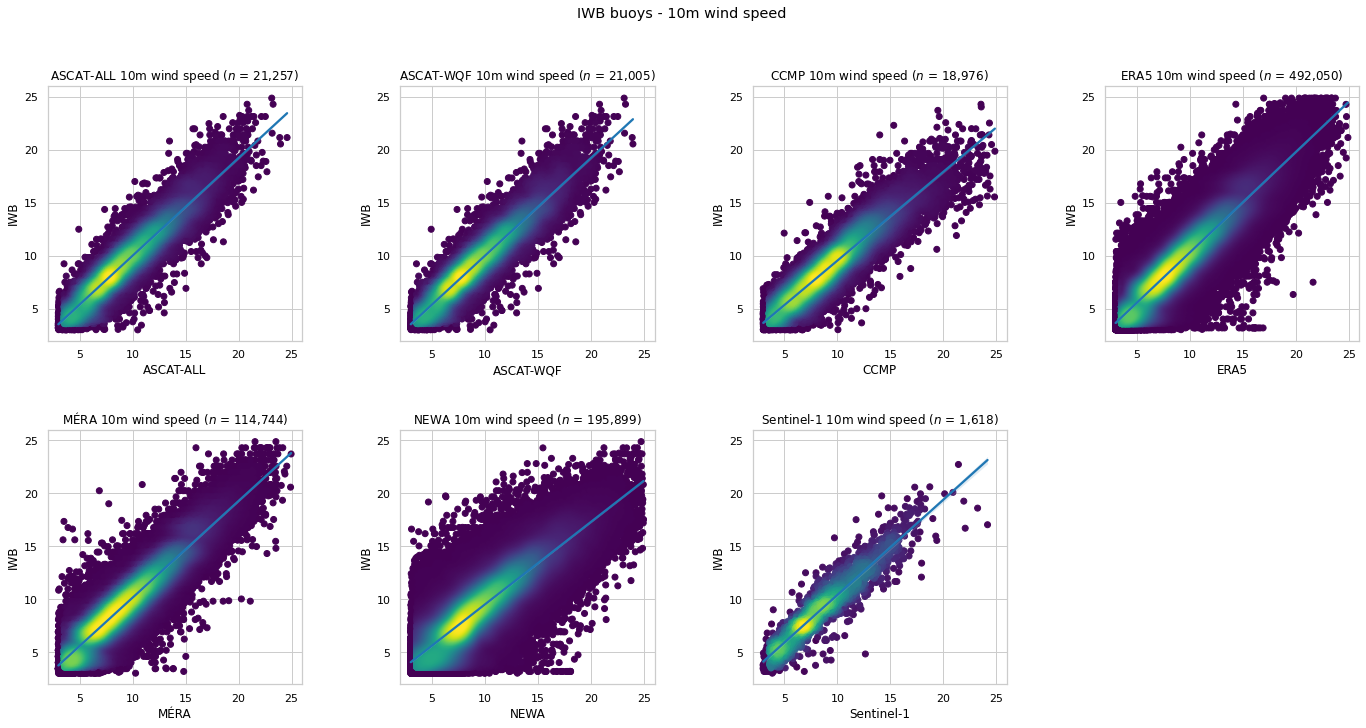

In [15]:
buoy_metrics(variable='wind_speed', height=10, variable_min=CUT_IN_WIND_SPEED, variable_max=CUT_OUT_WIND_SPEED)

---------------------------------
## Data Sets Wind Speed Comparison

In contrast to the previous section that compares IWB buoy data with corresponding satellite and reanalysis Zarr stores contained in the EOOffshore catalog, the remainder of this notebook focuses on comparisons between the Zarr stores. The approach is as follows:

1. Select a *reference* data set (analagous to the role of IWB data in the previous section).
1. Select one or more *test* data sets.
1. Select AOI subsets of the *reference* and *test* data sets, using IWB buoy and wind farm coordinates, and the `time` dimension.
1. Calculate metrics for each *reference*-*test* data set comparison, and generate corresponding density scatter plots, for the specified variable/height parameters.

Both the MÉRA and NEWA Zarr stores are used as *reference* data sets, as they provide data at multiple heights above the surface. They are not strictly considered as *ground truth* data sets, instead they are used here to demonstrate how the combination of the xarray, Dask, and Zarr libraries results in a scalable solution that can be applied to data sets of arbitrary sizes (related to heterogeneous spatial and temporal resolutions), as is the case with the EOOffshore catalog wind data sets. Parallel, out-of-core, computation of underlying variable chunks is achievable with identical calls to the xarray API. In the event of a future data set becoming available containing wind measurements at multiple heights (for example, LiDAR data) with high spatial coverage, it could be used as a more suitable *reference* data set.

Here are base classes that will be used for wind speed extrapolation. They are defined here as they are required for metrics calculation, and additional details will be provided later in this notebook.

In [16]:
class Extrapolator(ABC):
    """Base Extrapolator class"""
    
    @abstractmethod
    def extrapolate(self, ds: xr.Dataset, variable_name: str, heights: list[int]):
        """Extrapolate data set variable to required heights"""
        pass
    
    def _add_extrapolated_variable(self, ds: xr.Dataset, variable_name: str, extrapolated: dict, reindex_height: bool, variable_attrs: dict={}) -> xr.Dataset: 
        """Adds extrapolated values to existing variable, at height, and returns an updated Dataset"""
        height_attrs = ds.height.attrs
        ea = xr.concat([vda.assign_coords(height=height).expand_dims(['height']) for height, vda in extrapolated.items()], dim='height').sortby('height')
        if reindex_height:
            ds = ds.reindex({'height': ea.height}).chunk({'height':1})
        ds[variable_name] = ea
        # Height attributes are overwritten, restore them now
        ds.height.attrs.update(height_attrs)
        
        if variable_attrs:
            ds[variable_name].attrs.update(variable_attrs)
            
        return ds
    
class WindSpeedExtrapolator(Extrapolator):
    """Base wind speed Extrapolator class"""
    
    def extrapolate(self, ds: xr.Dataset, heights: list[int], variable_name: str = 'wind_speed'):
        """Extrapolate wind speed to required heights"""
        
        # Retain pre-existing height if required
        extrapolated_wind_speed = {height: ds[variable_name].sel(height=height) for height in ds.height.values if height not in heights}

        # Extrapolate to other heights
        for height in [h for h in heights if h not in extrapolated_wind_speed]:
            extrapolated_wind_speed[height] = self._extrapolate_wind_speed(ds=ds, variable_name=variable_name, extrapolation_height=height, reference_height=10)
        
        # Reindex height dimension if required
        reindex_height = len([h for h in heights if h not in ds.height.values]) > 0
        return self._add_extrapolated_variable(ds, variable_name, extrapolated_wind_speed, reindex_height=reindex_height)
    
    @abstractmethod
    def _extrapolate_wind_speed(self, ds: xr.Dataset, variable_name, extrapolation_height: int, reference_height: int) -> xr.DataArray:
        """Wind speed extrapolation method implementation"""
        pass

These classes implement *reference* and *test* data set comparison, enabling AOI subset matching, metrics calculation, and density scatter plot generation.

In [17]:
@dataclass
class AoiDatasetComparison:
    referenceds: xr.Dataset
    testds: xr.Dataset
    round_test_dataset_time: str = None
    
@dataclass
class AoiWindSpeedTestDataset:
    eooffshore_dataset: EooffshoreDataset
    extrapolator: WindSpeedExtrapolator = None

@dataclass
class AoiWindSpeedMetrics:
    reference_dataset: EooffshoreDataset = field(repr=False, hash=False, compare=False)
    reference_name: str = field(init=False)
    test_datasets: List[AoiWindSpeedTestDataset] = field(repr=False, hash=False, compare=False)
    comparison_height: int
    method: str = None
    variable: str = 'wind_speed'
    variable_min: float = CUT_IN_WIND_SPEED
    variable_max: float = CUT_OUT_WIND_SPEED
    variable_lim: Tuple[float, float] = field(init=False)
    buoys: List[str] = field(default_factory=lambda: ['M2', 'M3', 'M4', 'M5'])
    windfarms: List[str] = field(default_factory=lambda: eoowindfarmds.windfarms)
    discard_matches: bool = True
    matchesdf: pd.DataFrame = field(default=None, repr=False, hash=False, compare=False)
    metricsdf: pd.DataFrame = field(default=None, repr=False, hash=False, compare=False)
    
    def __post_init__(self):
        self._init_variables()
        self.compare_datasets()

    def _init_variables(self):
        """Perform extrapolation/estimation to required height"""
        self.reference_name = self.reference_dataset.name
        self.variable_lim = (int(self.variable_min)-1, int(self.variable_max)+1)

        for test_dataset in [x for x in self.test_datasets if x.extrapolator is not None]:
            test_dataset.eooffshore_dataset.dataset = test_dataset.extrapolator.extrapolate(ds=test_dataset.eooffshore_dataset.dataset, 
                                                                                            heights=[self.comparison_height])

    def compare_datasets(self):
        """Compare reference data set with all test data sets, for all IWB and wind farm AOIs"""
        for test_eooffshore_dataset in [x.eooffshore_dataset for x in self.test_datasets]:
            dataset_comparisons = [AoiDatasetComparison(referenceds=iwb.buoy_dataset(buoy, self.reference_dataset), 
                                                        testds=iwb.buoy_dataset(buoy, test_eooffshore_dataset),
                                                        round_test_dataset_time=test_eooffshore_dataset.round_test_dataset_time) for buoy in self.buoys]
            dataset_comparisons += [AoiDatasetComparison(referenceds=eoowindfarmds.windfarm_dataset(windfarm, self.reference_dataset, True), 
                                                         testds=eoowindfarmds.windfarm_dataset(windfarm, test_eooffshore_dataset, True),
                                                         round_test_dataset_time=test_eooffshore_dataset.round_test_dataset_time) for windfarm in self.windfarms]
            self._compare_test_dataset(dataset_comparisons, test_eooffshore_dataset.name)

        self._comparison_plot()

        dfstyle = {'$n$': '&nbsp;{:,.0f}'} 
        dfstyle.update({col: '&nbsp;{:.3f}' for col in self.metricsdf.columns[1:]})
        self.metricsdf = self.metricsdf.style.format(dfstyle)
        display(self.metricsdf)
        if self.discard_matches:
            self.matchesdf = None
        
    def _match_variables(self, dataset_comparison, name):
        """Match datasets on time and non-null variable values"""
        
        def preprocess_variable(ds, name, deduplicate_time=False):
            """Time-related preprocessing"""
            variable = ds.sel(height=self.comparison_height)[name]
            # Drop any null values prior to matching times
            variable = variable.where(variable.notnull(), drop=True)
            if deduplicate_time:
                # Remove any duplicated times
                variable = variable.sel(time=~variable.get_index('time').duplicated())
            return variable

        reference_variable = preprocess_variable(dataset_comparison.referenceds, name)
        test_variable = preprocess_variable(dataset_comparison.testds, name, deduplicate_time=True)
            
        if 'time' in test_variable.dims:
            # Match time
            if dataset_comparison.round_test_dataset_time is None:
                test_variable_time = test_variable.time.values
            else:
                test_variable_time = np.unique(test_variable.time.dt.round(dataset_comparison.round_test_dataset_time).values)
                
            reference_variable = reference_variable.sel(time=np.isin(reference_variable.time, test_variable_time))
            test_variable = test_variable.sel(time=reference_variable.time, method='nearest')
            
        return reference_variable, test_variable
        
    def _compare_test_dataset(self, dataset_comparisons: List[AoiDatasetComparison], test_name: str):
        """Compare reference-test data set pair for all AOIs"""
        test_matches = []
        for dataset_comparison in dataset_comparisons:
            reference_variable, test_variable = self._match_variables(dataset_comparison, self.variable)
        
            # Certain AOIs may not be found in the test dataset
            if len(test_variable) == 0:
                continue
                
            matchdf = pd.DataFrame({self.reference_name: reference_variable.values.reshape(-1,), 
                                    'Test': test_variable.values.reshape(-1,)})
            matchdf = matchdf.dropna()

            # Filter as required
            matchdf = matchdf[(matchdf[self.reference_name] >= self.variable_min) & (matchdf[self.reference_name] <= self.variable_max) & (matchdf.Test >= self.variable_min) & (matchdf.Test <= self.variable_max)]
            test_matches.append(matchdf)

        test_matchesdf = pd.concat(test_matches, ignore_index=True)
        test_matchesdf['Dataset'] = test_name
        self.matchesdf = pd.concat((self.matchesdf, test_matchesdf), ignore_index=True)        
        test_metricsdf = self._calculate_metrics(y_true=test_matchesdf[self.reference_name], 
                                                 y_pred=test_matchesdf.Test).to_frame().rename(columns={0: test_name}).T
        self.metricsdf = pd.concat((self.metricsdf, test_metricsdf))

    def _calculate_metrics(self, y_true: np.array, y_pred: np.array):
        """Calculate comparison metrics using true (reference) and predicted (test) values"""
        metrics = {'$n$': y_true.shape[0],
                   'RMSE': mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False),
                   'MAE': mean_absolute_error(y_true=y_true, y_pred=y_pred),
                   'Bias': np.mean(y_pred - y_true),
                   '$R^2$': r2_score(y_true=y_true, y_pred=y_pred),
                   '$r$': pearsonr(y_true, y_pred)[0]
                  }
        return pd.Series(metrics, name=None)

    def _comparison_plot(self):
        """Create a density scatter plot for all reference-test data set pairs"""
        num_test_datasets = len(self.test_datasets)
        ncols = 3 if num_test_datasets > 4 else num_test_datasets
        nrows = 2 if num_test_datasets > ncols else 1
        subplot_height = 5.5
        subplot_wspace = 0.25
        figwidth = 1 + (subplot_height + subplot_wspace) * ncols
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figwidth, subplot_height * nrows))
        plt.subplots_adjust(wspace=subplot_wspace, hspace=0.35)
        axes = axes.flatten() if num_test_datasets > 1 else [axes]

        variable_label = self.variable.replace('_', ' ')
        for i, test_name in enumerate(sorted(self.matchesdf.Dataset.unique())):
            ax = axes[i]
            test_matchesdf = self.matchesdf[self.matchesdf.Dataset==test_name]
            density_scatter_plot(x=test_matchesdf.Test.values, y=test_matchesdf[self.reference_name].values, ax=ax)
            sns.regplot(x='Test', y=self.reference_name, data=test_matchesdf, ax=ax, scatter=False);
            ax.set(adjustable='box', aspect='equal')
            ax.set_title(f'{test_name} {self.comparison_height}m {variable_label} ($n$ = {len(test_matchesdf):,})')
            ax.set_xlim(self.variable_lim)
            ax.set_ylim(self.variable_lim)
            ax.set_xlabel(test_name);
            ax.set_ylabel(self.reference_name);
        # Disable any axes if required
        for i in range(1, 1 + (ncols * nrows) - num_test_datasets):
            axes[-i].set_visible(False)
        fig.suptitle(f'{self.reference_name} {self.comparison_height}m {variable_label} (IWB buoy, wind farm AOIs)')

---------------------------------------
### 10m wind speed
This section provides 10m wind speed comparison outputs

------------------------------------------------------
#### MÉRA 10m wind speed

MÉRA 10m wind speed is compared with corresponding wind speed provided by other data sets at the IWB buoy and wind farm AOI coordinates.
* Sentinel-1 is excluded as data starts from mid-2017, while MÉRA provides data until the end of 2016.
* The M6 IWB buoy is excluded as NEWA data is unavailable for these coordinates

,$n$,RMSE,MAE,Bias,$R^2$,$r$
ASCAT-ALL,"5,363",1.393,1.059,-0.151,0.847,0.921
ASCAT-WQF,"4,495",1.368,1.049,-0.200,0.852,0.925
CCMP,"11,225",1.496,1.141,0.172,0.816,0.911
ERA5,"370,942",1.442,1.113,-0.731,0.832,0.937
NEWA,"184,816",1.792,1.326,0.142,0.743,0.875


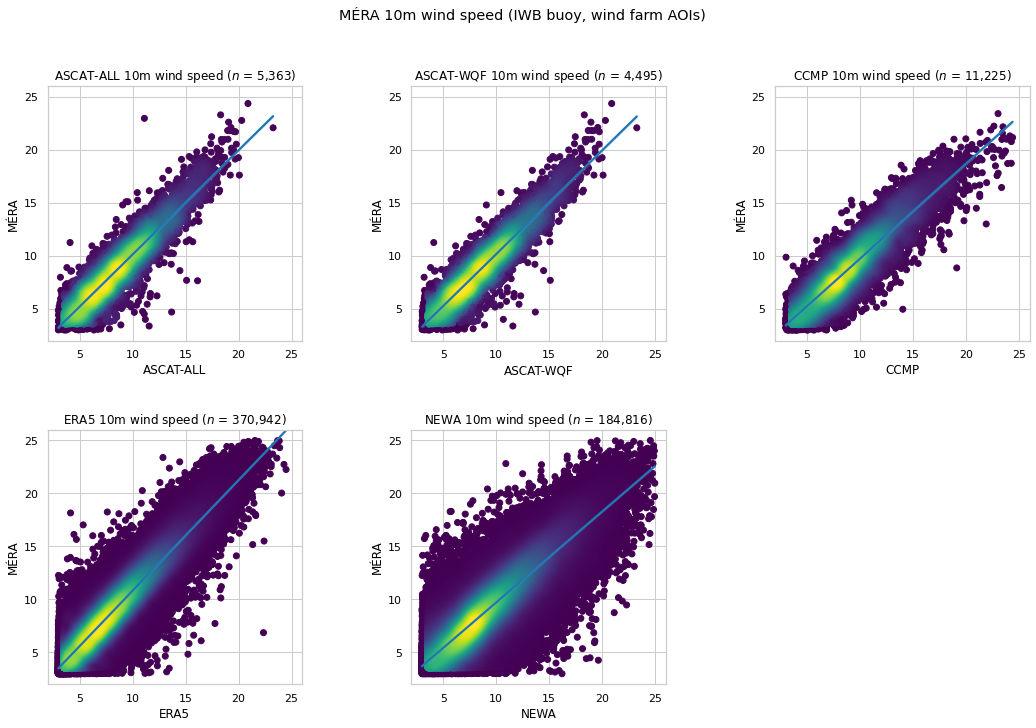

In [18]:
AoiWindSpeedMetrics(reference_dataset=mera,
                    test_datasets=[AoiWindSpeedTestDataset(eooffshore_dataset=x) for x in [ascatall, ascatwqf, ccmp, era5, newa]],
                    comparison_height=10);

------------------------------------------
#### NEWA 10m wind speed

NEWA 10m wind speed is compared with corresponding wind speed provided by other data sets at the IWB buoy and wind farm AOI coordinates.
* Sentinel-1 is included as NEWA provides data until the end of 2016.
* The M6 IWB buoy is excluded as NEWA data is unavailable for these coordinates

,$n$,RMSE,MAE,Bias,$R^2$,$r$
ASCAT-ALL,"24,829",1.733,1.288,-0.255,0.770,0.881
ASCAT-WQF,"20,828",1.699,1.262,-0.289,0.782,0.888
CCMP,"20,665",1.627,1.216,0.052,0.786,0.895
ERA5,"689,818",1.936,1.465,-0.899,0.709,0.878
MÉRA,"184,816",1.792,1.326,-0.142,0.753,0.875
Sentinel-1,"2,325",2.317,1.822,-1.264,0.572,0.838


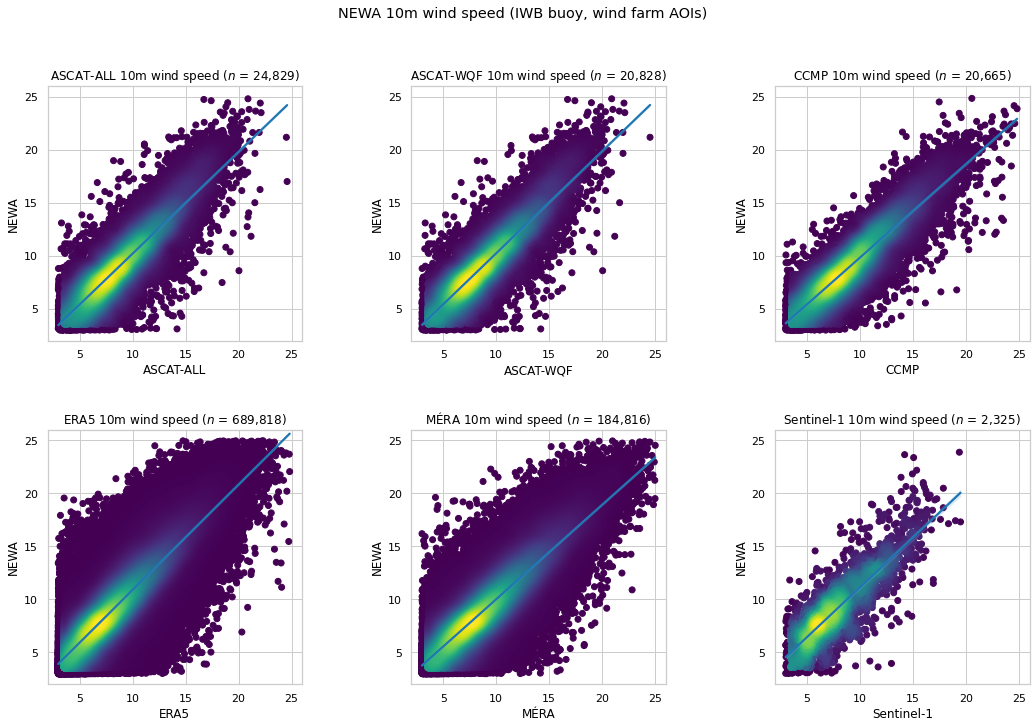

In [19]:
AoiWindSpeedMetrics(reference_dataset=newa,
                    test_datasets=[AoiWindSpeedTestDataset(eooffshore_dataset=x) for x in [ascatall, ascatwqf, ccmp, era5, mera, sentinel1]],
                    comparison_height=10);

---------------------------------
## Wind Speed Extrapolation


Wind speed extrapolation is the process of extrapolating data values at provided heights to one or more required heights for which data is unavailable, generating a wind speed profile at an AOI. For satellite or reanalysis, data is usually restricted to values at 10m above the surface level. Consequently, extrapolation may be used with these 10m data to generate wind speed values at typical [wind turbine hub heights](https://www.wind-energy-the-facts.org/hub-height.html). The following publications provide examples of wind speed extrapolation:

* [Badger et al. (2016) - Extrapolating Satellite Winds to Turbine Operating Heights](https://doi.org/10.1175/JAMC-D-15-0197.1)
* [Shu et al. (2016) - Observations of offshore wind characteristics by Doppler-LiDAR for wind energy applications](https://doi.org/10.1016/j.apenergy.2016.01.135)
* [Carvalho et al. (2017) - Offshore winds and wind energy production estimates derived from ASCAT, OSCAT, numerical
weather prediction models and buoys – A comparative study for the Iberian Peninsula Atlantic coast](https://doi.org/10.1016/j.renene.2016.10.063)
* [Karagali et al. (2018) - New European wind atlas offshore](https://iopscience.iop.org/article/10.1088/1742-6596/1037/5/052007)
* [Remmers et al. (2019) - The Potential of Advanced Scatterometer (ASCAT) 12.5 km Coastal Observations for Offshore Wind Farm Site Selection in Irish Waters](https://doi.org/10.3390/en12020206)
* [de Montera et al. (2020) - Validation of Sentinel-1 offshore winds and average wind power estimation around Ireland](https://doi.org/10.5194/wes-5-1023-2020)
* [Schelbergen et al. (2020) - Clustering wind profile shapes to estimate airborne wind energy production](https://doi.org/10.5194/wes-5-1097-2020)
* [Xu et al. (2020) - Proliferation of offshore wind farms in the North Sea and surrounding waters revealed by satellite image time series](https://doi.org/10.1016/j.rser.2020.110167)

This section is not intended to be a complete analysis of possible extrapolation methods. Instead, its objective is to demonstrate how a comparison of methods may be implemented using the scalable approach offered by the combination of the xarray, Dask and Zarr libraries, applied to data at multiple heights provided by MÉRA and NEWA.

-----------------------------------------
### Power law extrapolation

The power law method is often used for extrapolating 10m wind speed observations to hub heights (for example, [Remmers et al., 2019](https://doi.org/10.3390/en12020206); [Schelbergen et al., 2020](https://doi.org/10.5194/wes-5-1097-2020)). It is defined as follows ([Hsu et al., 1994 - Determining the Power-Law Wind-Profile Exponent under Near-Neutral Stability Conditions at Sea](https://journals.ametsoc.org/view/journals/apme/33/6/1520-0450_1994_033_0757_dtplwp_2_0_co_2.xml)):

$u = u_r\left(\dfrac{z}{z_r}\right)^\alpha$

* $u$: wind speed ($m s^{-1}$) at required height $z$ ($m$) 
* $z_r$: reference height (e.g. 10m for data provided by ERA5, Sentinel-1 etc.)
* $u_r$: wind speed at $z_r$
* $\alpha$: function of atmospheric stability and surface characteristics

This class provides an implementation of power law extrapolation that will operate on the EOOffshore Zarr stores

In [20]:
class PowerLawWindSpeedExtrapolator(WindSpeedExtrapolator):
    """Wind speed Extrapolator implementation, using the power law method"""
    alpha: float = 0.11 # Hsu 1994

    def __init__(self, alpha: float=0.11):
        self.alpha = alpha
    
    def _extrapolate_wind_speed(self, ds: xr.Dataset, variable_name: str, extrapolation_height: int, reference_height: int) -> xr.DataArray:
        """Wind speed extrapolation method implementation"""
        return ds[variable_name].sel(height=reference_height) * (extrapolation_height/reference_height)**self.alpha
    
powerlaw_extrapolator = PowerLawWindSpeedExtrapolator()

-----------------------------------------------
#### MÉRA 125m wind speed comparison

10m wind speed is extrapolated using the power law method, and compared with the corresponding MÉRA 125m wind speed at the IWB buoy and wind farm AOI coordinates.

This data structure is used to record wind speed extrapolation comparison metrics obtained throughout this notebook

In [21]:
wind_speed_extrapolation_metrics = []

,$n$,RMSE,MAE,Bias,$R^2$,$r$
ASCAT-ALL,"5,521",2.185,1.721,0.740,0.744,0.889
ASCAT-WQF,"4,627",2.152,1.699,0.730,0.753,0.894
CCMP,"11,461",2.504,1.995,1.259,0.651,0.881
ERA5,"385,710",1.668,1.299,0.058,0.853,0.924


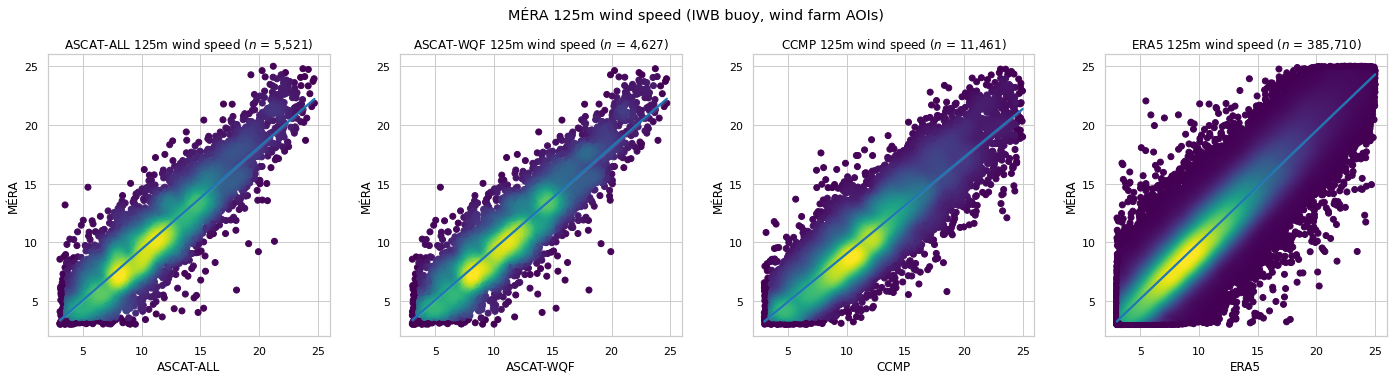

In [22]:
test_datasets = [AoiWindSpeedTestDataset(eooffshore_dataset=ascatall, extrapolator=powerlaw_extrapolator),
                 AoiWindSpeedTestDataset(eooffshore_dataset=ascatwqf, extrapolator=powerlaw_extrapolator),
                 AoiWindSpeedTestDataset(eooffshore_dataset=ccmp, extrapolator=powerlaw_extrapolator),
                 AoiWindSpeedTestDataset(eooffshore_dataset=era5, extrapolator=powerlaw_extrapolator)]

wind_speed_extrapolation_metrics.append(AoiWindSpeedMetrics(reference_dataset=mera,
                                                            test_datasets=test_datasets,
                                                            comparison_height=125,
                                                            method='Power Law'))

----------------------------------------
#### NEWA 150m wind speed comparison 

150m wind speed is extrapolated using the power law method, and compared with the corresponding NEWA 150m wind speed at the IWB buoy and wind farm AOI coordinates.

,$n$,RMSE,MAE,Bias,$R^2$,$r$
ASCAT-ALL,"25,408",2.814,2.215,1.013,0.610,0.828
ASCAT-WQF,"21,274",2.785,2.198,1.027,0.622,0.835
CCMP,"21,078",2.964,2.342,1.480,0.526,0.837
ERA5,"716,184",2.277,1.748,0.144,0.741,0.866
Sentinel-1,"2,424",2.813,2.167,-0.306,0.580,0.791


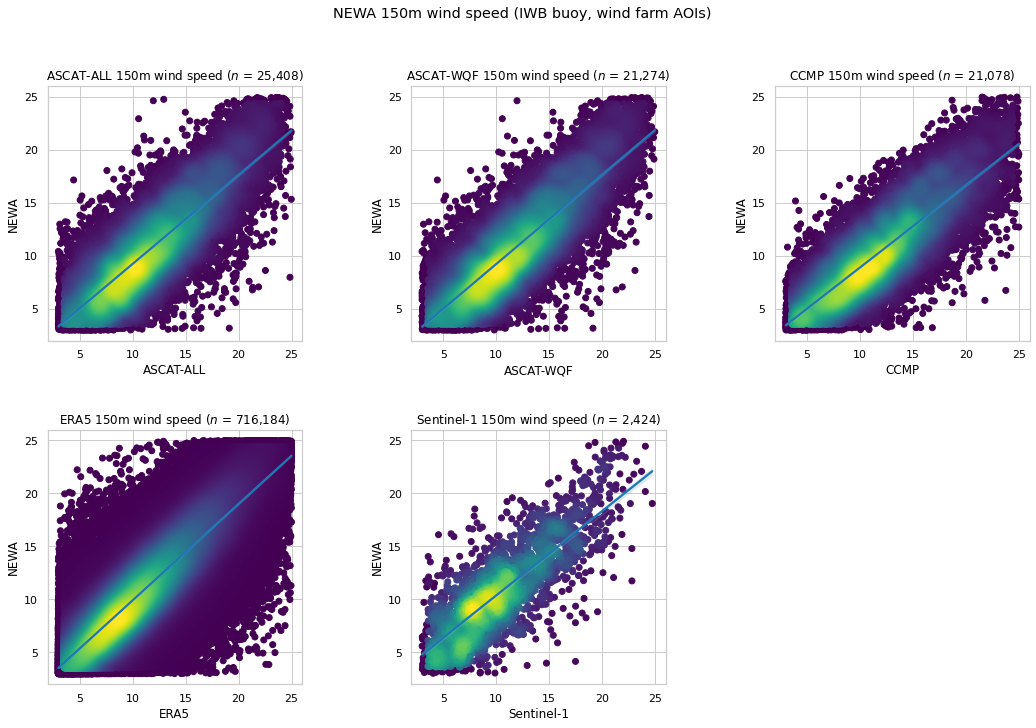

In [23]:
test_datasets = [AoiWindSpeedTestDataset(eooffshore_dataset=ascatall, extrapolator=powerlaw_extrapolator),
                 AoiWindSpeedTestDataset(eooffshore_dataset=ascatwqf, extrapolator=powerlaw_extrapolator),
                 AoiWindSpeedTestDataset(eooffshore_dataset=ccmp, extrapolator=powerlaw_extrapolator),
                 AoiWindSpeedTestDataset(eooffshore_dataset=era5, extrapolator=powerlaw_extrapolator),
                 AoiWindSpeedTestDataset(eooffshore_dataset=sentinel1, extrapolator=powerlaw_extrapolator)
                ]

wind_speed_extrapolation_metrics.append(AoiWindSpeedMetrics(reference_dataset=newa,
                                                            test_datasets=test_datasets,
                                                            comparison_height=150,
                                                            method='Power Law'))

-------------------------------------
#### Power law $\alpha$ estimation

A value of $\alpha$ = 0.1 or 0.11 is often used as a good approximation for use at sea with the power law method ([Hsu et al., 1994](https://journals.ametsoc.org/view/journals/apme/33/6/1520-0450_1994_033_0757_dtplwp_2_0_co_2.xml)). However, the positive Bias obtained with the corresponding comparisons (in contrast to the 10m comparisons Bias) may identify that the extrapolated wind speeds are overestimated, suggesting that an alternative $\alpha$ value may be more suitable. For example, the ERA5 data set provides wind speed at both 10m and 100m, which may be used to calculate $\alpha$ as follows:

$\alpha = \dfrac{\mathrm{ln}\left(\dfrac{u_2}{u_1}\right)}{\mathrm{ln}\left(\dfrac{z_2}{z_1}\right)}$

* $z_1$: height 1, e.g. 10m
* $z_2$: height 2, e.g. 100m
* $u_1$: wind speed ($m s^{-1}$) at height $z_1$, e.g. ERA5 10m wind speed
* $u_2$: wind speed ($m s^{-1}$) at height $z_2$, e.g. ERA5 100m wind speed

Here, the following are computed:
1. An ERA5 `powerlaw_alpha` variable, computed at each time for all grid coordinates. This will be used for extrapolating ERA5 10m wind speed to heights other than 100m.
1. A power law extrapolator using `powerlaw_alpha`.

**Note:**
* **xarray provides implementations of certain [NumPy niversal functions (ufunc)](https://numpy.org/doc/stable/reference/ufuncs.html), including [`xarray.ufuncs.log()`](https://xarray.pydata.org/en/stable/generated/xarray.ufuncs.log.html) as used to calculate $\alpha$. Using ufuncs ensures that lazy computation applies, i.e. the corresponding Dask graph execution does not occur until `compute()` is called.**

In [24]:
default_powerlaw_era5 = copy.deepcopy(era5)
default_powerlaw_era5.name='ERA5 (alpha=0.11)'

alpha_powerlaw_era5 = copy.deepcopy(era5)
alpha_powerlaw_era5.name='ERA5 (alpha=ERA5)'

era5.dataset['powerlaw_alpha'] = (xr.ufuncs.log(era5.dataset.wind_speed.sel(height=100)/era5.dataset.wind_speed.sel(height=10))/math.log(100/10))

era5_alpha_powerlaw_extrapolator = PowerLawWindSpeedExtrapolator(alpha=era5.dataset.powerlaw_alpha)

ERA5 10m wind speed is extrapolated using the Power Law method with `power_alpha`, and compared with the corresponding ERA5 15m wind speed at the IWB buoy and wind farm AOI coordinates.

,$n$,RMSE,MAE,Bias,$R^2$,$r$
ERA5 (alpha=0.11),"1,520,056",0.823,0.689,0.325,0.961,0.984
ERA5 (alpha=ERA5),"1,527,165",0.000,0.000,-0.000,1.000,1.000


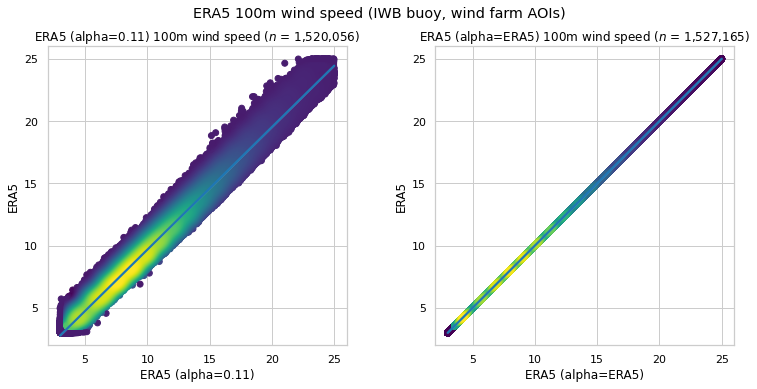

In [25]:
test_datasets=[AoiWindSpeedTestDataset(eooffshore_dataset=default_powerlaw_era5, extrapolator=powerlaw_extrapolator),
               AoiWindSpeedTestDataset(eooffshore_dataset=alpha_powerlaw_era5, extrapolator=era5_alpha_powerlaw_extrapolator)
              ]
AoiWindSpeedMetrics(reference_dataset=era5,
                    test_datasets=test_datasets,
                    comparison_height=100);

An exact match with no errors is obtained. Here is the ERA5 `power_alpha` distribution

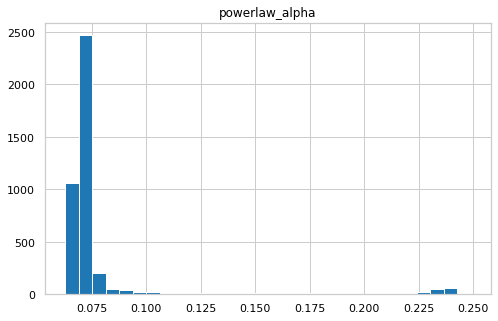

In [26]:
mean_alphadf = era5.dataset.powerlaw_alpha.mean(dim='time').to_dataframe()
mean_alphadf.hist(bins=30);

In [27]:
mean_alphadf.describe().T

,count,mean,std,min,25%,50%,75%,max
powerlaw_alpha,4165.0,0.080109,0.034877,0.06259,0.06878,0.070319,0.072935,0.249005


Power Law extrapolation comparisons are now made as follows:
1. ERA5 10m wind speed will be extrapolated using the `powerlaw_alpha` variable, computed at each time for all grid coordinates.
1. A power law extrapolator with $\alpha$ = mean ERA5 `powerlaw_alpha` will be used for the other data sets.

In [28]:
mean_era5_alpha_powerlaw_extrapolator = PowerLawWindSpeedExtrapolator(alpha=mean_alphadf.powerlaw_alpha.mean())

------------------------------
#### MÉRA 125m wind speed comparison using ERA5 power law $\alpha$

,$n$,RMSE,MAE,Bias,$R^2$,$r$
ASCAT-ALL,"5,509",1.990,1.542,-0.071,0.789,0.890
ASCAT-WQF,"4,614",1.957,1.520,-0.086,0.797,0.895
CCMP,"11,482",2.117,1.655,0.438,0.758,0.884
ERA5,"383,488",1.427,1.075,-0.309,0.891,0.947


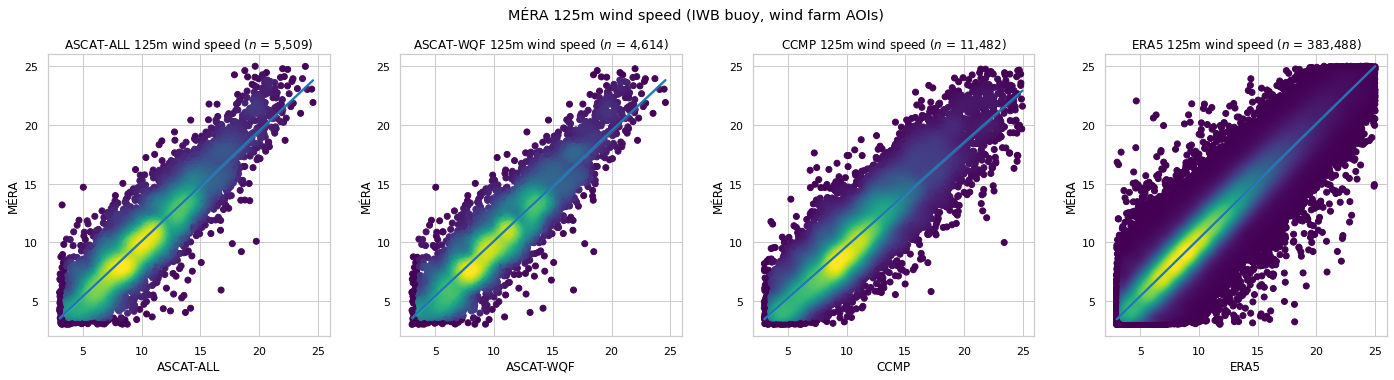

In [29]:
test_datasets = [AoiWindSpeedTestDataset(eooffshore_dataset=ascatall, extrapolator=mean_era5_alpha_powerlaw_extrapolator),
                 AoiWindSpeedTestDataset(eooffshore_dataset=ascatwqf, extrapolator=mean_era5_alpha_powerlaw_extrapolator),
                 AoiWindSpeedTestDataset(eooffshore_dataset=ccmp, extrapolator=mean_era5_alpha_powerlaw_extrapolator),
                 AoiWindSpeedTestDataset(eooffshore_dataset=era5, extrapolator=era5_alpha_powerlaw_extrapolator)]

wind_speed_extrapolation_metrics.append(AoiWindSpeedMetrics(reference_dataset=mera,
                                                            test_datasets=test_datasets,
                                                            comparison_height=125,
                                                            method='Power Law (ERA5-based alpha)'))

------------------------------
#### NEWA 150m wind speed comparison using ERA5 power law $\alpha$

,$n$,RMSE,MAE,Bias,$R^2$,$r$
ASCAT-ALL,"25,363",2.559,1.993,0.126,0.680,0.829
ASCAT-WQF,"21,232",2.523,1.966,0.133,0.692,0.836
CCMP,"21,109",2.531,1.975,0.597,0.664,0.841
ERA5,"711,857",1.983,1.453,-0.255,0.803,0.899
Sentinel-1,"2,410",2.930,2.282,-1.105,0.544,0.791


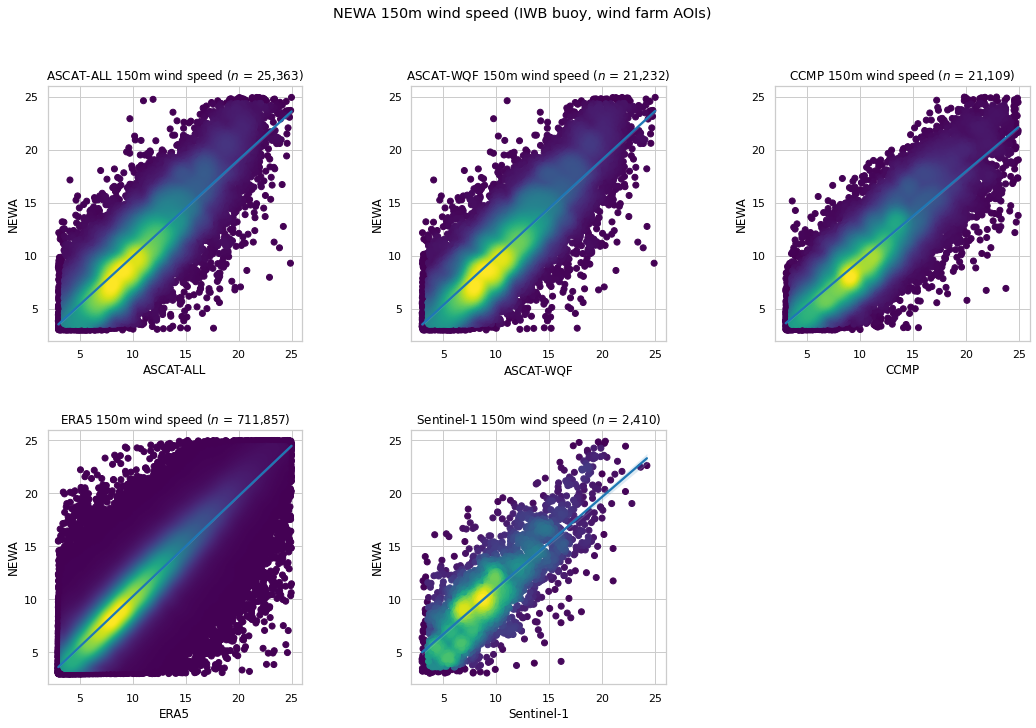

In [30]:
test_datasets = [AoiWindSpeedTestDataset(eooffshore_dataset=ascatall, extrapolator=mean_era5_alpha_powerlaw_extrapolator),
                 AoiWindSpeedTestDataset(eooffshore_dataset=ascatwqf, extrapolator=mean_era5_alpha_powerlaw_extrapolator),
                 AoiWindSpeedTestDataset(eooffshore_dataset=ccmp, extrapolator=mean_era5_alpha_powerlaw_extrapolator),
                 AoiWindSpeedTestDataset(eooffshore_dataset=era5, extrapolator=era5_alpha_powerlaw_extrapolator),
                 AoiWindSpeedTestDataset(eooffshore_dataset=sentinel1, extrapolator=mean_era5_alpha_powerlaw_extrapolator),
                ]

wind_speed_extrapolation_metrics.append(AoiWindSpeedMetrics(reference_dataset=newa,
                                                            test_datasets=test_datasets,
                                                            comparison_height=150,
                                                            method='Power Law (ERA5-based alpha)'))

--------------------------------------
### Log law extrapolation

The log law method is an alternative extrapolation method. Here, it is implemented as defined by [Remmers et al., 2019](https://doi.org/10.3390/en12020206):

$u = \dfrac{\mathrm{ln}\left(\dfrac{z}{z_0}\right)}{\mathrm{ln}\left(\dfrac{z_r}{z_0}\right)} \times u_r$

* $u$: wind speed ($m s^{-1}$) at required height $z$ ($m$)
* $z_r$: reference height (3m in the case of IWB data, 10m in the case of ERA5 data etc.)
* $u_r$: wind speed at $z_r$ (provided wind speed)
* $z_0$: surface roughness

In [31]:
class LogLawWindSpeedExtrapolator(WindSpeedExtrapolator):
    """Wind speed Extrapolator implementation, using the log law method as defined in Remmers et al., 2019"""
    z0: float = 0.0002 # surface roughness length

    def __init__(self, z0: float=0.0002):
        self.z0 = z0
    
    def _extrapolate_wind_speed(self, ds: xr.Dataset, variable_name: str, extrapolation_height: int, reference_height: int) -> xr.DataArray:
        """Wind speed extrapolation method implementation"""
        # Use the implementation defined earlier in this notebook
        return loglaw_extrapolate(z=extrapolation_height, wind_speed=ds[variable_name].sel(height=reference_height), zref=reference_height, z0=self.z0)

loglaw_extrapolator = LogLawWindSpeedExtrapolator()

------------------------------------
#### MÉRA 125m wind speed comparison

10m wind speed is extrapolated using the log law method, and compared with the corresponding MÉRA 125m wind speed at the IWB buoy and wind farm AOI coordinates.

,$n$,RMSE,MAE,Bias,$R^2$,$r$
ASCAT-ALL,"5,512",1.993,1.546,0.006,0.788,0.890
ASCAT-WQF,"4,615",1.959,1.524,-0.007,0.796,0.895
CCMP,"11,477",2.142,1.678,0.518,0.751,0.884
ERA5,"384,064",1.772,1.363,-0.621,0.834,0.924


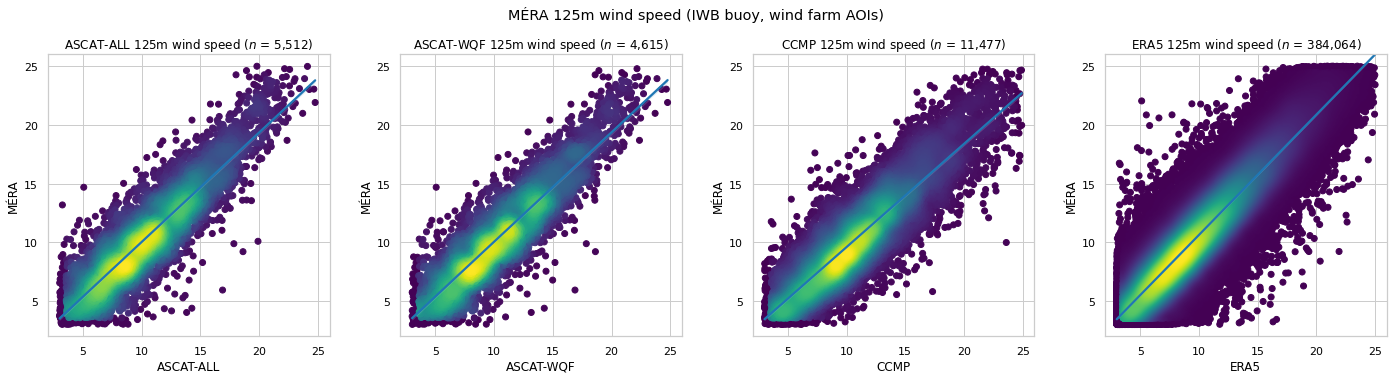

In [32]:
test_datasets = [AoiWindSpeedTestDataset(eooffshore_dataset=ascatall, extrapolator=loglaw_extrapolator),
                 AoiWindSpeedTestDataset(eooffshore_dataset=ascatwqf, extrapolator=loglaw_extrapolator),
                 AoiWindSpeedTestDataset(eooffshore_dataset=ccmp, extrapolator=loglaw_extrapolator),
                 AoiWindSpeedTestDataset(eooffshore_dataset=era5, extrapolator=loglaw_extrapolator)]

wind_speed_extrapolation_metrics.append(AoiWindSpeedMetrics(reference_dataset=mera,
                                                            test_datasets=test_datasets,
                                                            comparison_height=125,
                                                            method='Log Law'))

------------------------------------
#### NEWA 150m wind speed comparison

10m wind speed is extrapolated using the log law method, and compared with the corresponding NEWA 150m wind speed at the IWB buoy and wind farm AOI coordinates.

,$n$,RMSE,MAE,Bias,$R^2$,$r$
ASCAT-ALL,"25,368",2.565,2.000,0.194,0.679,0.829
ASCAT-WQF,"21,238",2.529,1.973,0.202,0.691,0.836
CCMP,"21,104",2.554,1.995,0.665,0.658,0.841
ERA5,"712,940",2.324,1.782,-0.607,0.731,0.866
Sentinel-1,"2,410",2.912,2.265,-1.043,0.550,0.791


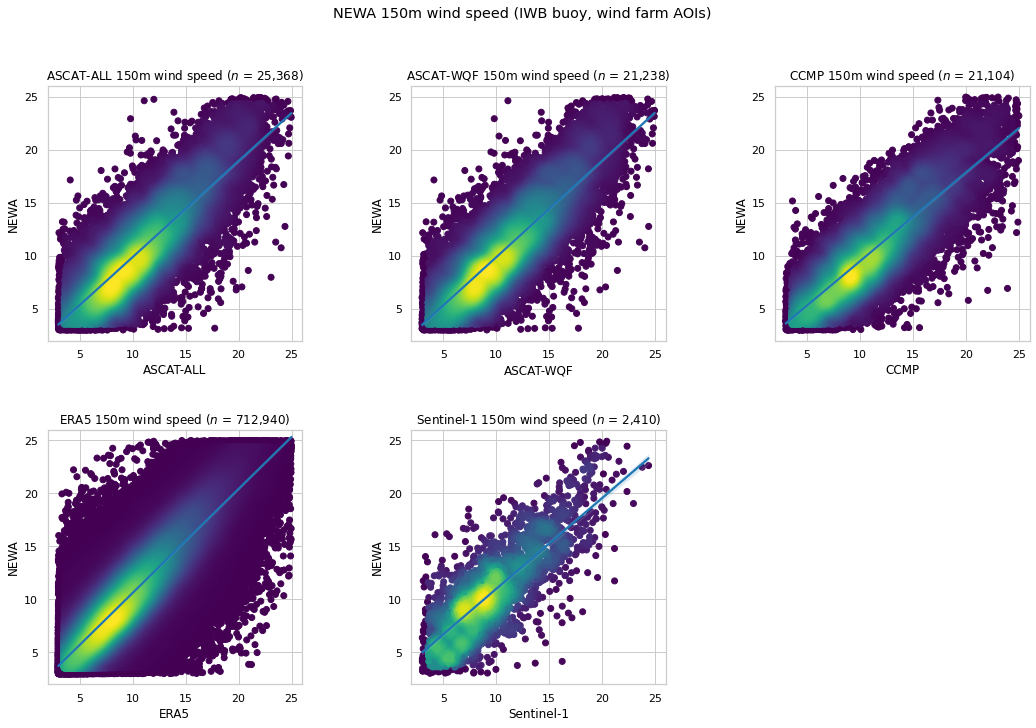

In [33]:
test_datasets = [AoiWindSpeedTestDataset(eooffshore_dataset=ascatall, extrapolator=loglaw_extrapolator),
                 AoiWindSpeedTestDataset(eooffshore_dataset=ascatwqf, extrapolator=loglaw_extrapolator),
                 AoiWindSpeedTestDataset(eooffshore_dataset=ccmp, extrapolator=loglaw_extrapolator),
                 AoiWindSpeedTestDataset(eooffshore_dataset=era5, extrapolator=loglaw_extrapolator),
                 AoiWindSpeedTestDataset(eooffshore_dataset=sentinel1, extrapolator=loglaw_extrapolator),
                ]

wind_speed_extrapolation_metrics.append(AoiWindSpeedMetrics(reference_dataset=newa,
                                                            test_datasets=test_datasets,
                                                            comparison_height=150,
                                                            method='Log Law'))

------------------------------------------
### Extrapolation metrics review

The following tables contain the extrapolation metrics obtained from the MÉRA and NEWA comparisons, where the "best" scores are highlighted. 

In [34]:
def dataset_metrics_table(metrics: List[AoiWindSpeedMetrics]) -> pd.DataFrame:
    """Display comparison metrics, highlighting best scores"""
    dataset_metrics=[]
    for method_metrics in metrics:
        metricsdf = method_metrics.metricsdf.data.reset_index()
        mdf = metricsdf.copy(deep=True).rename(columns={'index': 'Dataset'})
        mdf.insert(loc=1, column='Method', value=method_metrics.method)
        dataset_metrics.append(mdf)
    
    dataset_metricsdf = pd.concat(dataset_metrics, ignore_index=True).sort_values(by='Dataset').set_index(['Dataset', 'Method'])
    dfstyle = {'$n$': '{:,.0f}'}
    dfstyle.update({col: '{:.3f}' for col in dataset_metricsdf.columns[1:]})
    
    highlight_props = 'color:white;background-color:darkblue'

    def highlight_max(s, props=highlight_props):
        return np.where(s == np.nanmax(s.values), props, '')

    def highlight_min(s, props=highlight_props):
        values = np.abs(s.values)
        return np.where(values == np.nanmin(values), props, '')

    idx = pd.IndexSlice
    styleddf = dataset_metricsdf.style

    for dataset in dataset_metricsdf.index.unique(level=0):
        min_slice_ = idx[idx[dataset,:], idx['RMSE':'Bias']]
        max_slice_ = idx[idx[dataset,:], idx['$R^2$':'$r$']]
        styleddf = styleddf.apply(highlight_min, axis=0, subset=min_slice_)\
                           .apply(highlight_max, axis=0, subset=max_slice_)
    return styleddf.format(dfstyle)


reference_wind_speed_metrics = defaultdict(list)
for m in wind_speed_extrapolation_metrics:
    reference_wind_speed_metrics[m.reference_name].append(m)

for reference_dataset_label, method_metrics in reference_wind_speed_metrics.items():
    display(Markdown('-----------------'))
    display(Markdown(f'**Wind Speed Extrapolation Methods: compared with {reference_dataset_label}**'))
    display(dataset_metrics_table(method_metrics))
    print('\n')

-----------------

**Wind Speed Extrapolation Methods: compared with MÉRA**

-----------------

**Wind Speed Extrapolation Methods: compared with NEWA**

---------------------------------
## Power Density Estimation

Offshore wind power density estimates may be generated for an AOI using the available wind speed values at the corresponding coordinates. When used in combination with wind speed extrapolation as described above, it is possible to estimate power at typical wind turbine hub heights. The following publications provide examples of power density estimation using wind speed:

* [Pryor et al. (2004) - Can Satellite Sampling of Offshore Wind Speeds Realistically Represent Wind Speed Distributions? Part II: Quantifying Uncertainties Associated with Distribution Fitting Methods](https://doi.org/10.1175/2096.1)
* [Doubrawa et al. (2015) - Satellite winds as a tool for offshore wind resource assessment: The Great Lakes Wind Atlas](https://doi.org/10.1016/j.rse.2015.07.008)
* [Hasager et al. (2015) - Offshore wind climatology based on synergetic use of Envisat ASAR, ASCAT and QuikSCAT](https://doi.org/10.1016/j.rse.2014.09.030)
* [Badger et al. (2016) - Extrapolating Satellite Winds to Turbine Operating Heights](https://doi.org/10.1175/JAMC-D-15-0197.1)
* [Shu et al. (2016) - Observations of offshore wind characteristics by Doppler-LiDAR for wind energy applications](https://doi.org/10.1016/j.apenergy.2016.01.135)
* [Remmers et al. (2019) - The Potential of Advanced Scatterometer (ASCAT) 12.5 km Coastal Observations for Offshore Wind Farm Site Selection in Irish Waters](https://doi.org/10.3390/en12020206)
* [Ahsbahs et al. (2020) - US East Coast synthetic aperture radar wind atlas for offshore wind energy](https://doi.org/10.5194/wes-5-1191-2020)
* [de Montera et al. (2020) - Validation of Sentinel-1 offshore winds and average wind power estimation around Ireland](https://doi.org/10.5194/wes-5-1023-2020)
* [Xu et al. (2020) - Proliferation of offshore wind farms in the North Sea and surrounding waters revealed by satellite image time series](https://doi.org/10.1016/j.rser.2020.110167)

--------------------------------------
### Estimation implementation

Power density estimation at multiple heights is implemented as an `Extrapolator`, as used for wind speed extrapolation above. Here is the base class used for all implementations.

In [35]:
class PowerDensityEstimator(Extrapolator):
    """Base power density estimator class, implemented as an Extrapolator to reuse the creation of new variables with height dimension"""
    attrs: dict[str, str] = {
                            'long_name': 'Power density (estimated using wind speed)',
                            'units': 'Wm**-2'
                            }
    
    min_wind_speed: float = CUT_IN_WIND_SPEED
    max_wind_speed: float = CUT_OUT_WIND_SPEED
    wind_speed_variable_name: str = 'wind_speed'

    def __init__(self, air_density: float=1.225):
        self.air_density = air_density

    def extrapolate(self, ds: xr.Dataset, heights: list[int], variable_name: str = 'power_density'):
        """Estimate power density at required heights"""
        estimated_power_density = {height: self._estimate_power_density(wind_speed=self._filter_wind_speed(ds[self.wind_speed_variable_name].sel(height=height)))
                                           for height in heights}
        
        return self._add_extrapolated_variable(ds, variable_name, estimated_power_density, reindex_height=False, variable_attrs=self.attrs)

    def _filter_wind_speed(self, wind_speed: xr.DataArray):
        """Filters to turbine cut in/out range"""
        return wind_speed.where((wind_speed >= self.min_wind_speed) & (wind_speed <= self.max_wind_speed))
        
    @abstractmethod
    def _estimate_power_density(self, wind_speed: xr.DataArray) -> xr.DataArray:
        """Power density estimation implementation"""
        pass

-----------------------------------
### Power Density Estimation using cubed wind speed

When a data set provides a complete time series of wind speed observations, power density may be estimated from the cube of the wind speed ([de Montera et al., 2020](https://doi.org/10.5194/wes-5-1023-2020)):

$P = \dfrac{1}{2}\rho U^3$

* $P$: wind power  density ($W m^{-2}$)
* $\rho$: air density ($kg$ $m^{-3}$), a default value of 1.225 is typically used over oceans
* $U$: wind speed ($m s^{-1}$)

In [36]:
class CubedWindSpeedPowerDensityEstimator(PowerDensityEstimator):
    """Power density estimation using complete wind speed time series"""

    def _estimate_power_density(self, wind_speed: xr.DataArray) -> xr.DataArray:
        """Power density estimation implementation"""
        return 0.5 * self.air_density * (wind_speed**3)

-----------------------------------------
### AOI wind speed distributions and Weibull parameters

AOI wind speed is typically represented by a Weibull distribution of observations, characterized by a shape parameter ($k$, dimensionless) and a scale parameter ($\lambda$, $m s^{-1}$) ([Ahsbahs et al., 2020](https://doi.org/10.5194/wes-5-1191-2020)). The Weibull probability density function (PDF) is as follows:

$\mathrm{PDF}(U) = \dfrac{k}{\lambda}\left(\dfrac{U}{k} \right)^{k-1} \epsilon^{-(U/\lambda)^k}$

A minimum number of observations or samples are required for Weibull parameter fitting, this is relevant for SAR data such as the [Sentinel-1 data set](./Sentinel-1_ICS_Wind_Data.ipynb). Consequently, wind speeds from all directional sectors have been used for fitting ([Badger et al., 2016](https://doi.org/10.1175/JAMC-D-15-0197.1)), where the same process is applied in this notebook. 

Mean wind power density is related to the corresponding Weibull parameters as follows ([Ahsbahs et al., 2020](https://doi.org/10.5194/wes-5-1191-2020)):

$P = \dfrac{1}{2}\rho \lambda^3 \Gamma \left(1 + \dfrac{3}{k}\right)$

* $P$: wind power density ($W m^{-2}$)
* $U$: wind speed ($m s^{-1}$)
* $\rho$: air density ($kg$ $m^{-3}$), a default value of 1.225 is typically used over oceans
* $\Gamma$: gamma function ([`scipy.special.gamma()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gamma.html) is used in this notebook)
* $k$: Weibull shape parameter (dimensionless)
* $\lambda$: Weibull scale parameter ($m s^{-1}$)

Using the [`scipy.stats.weibull_min()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.weibull_min.html) implementation for Weibull parameter fitting is sufficient for individual AOI assessment. This approach does not scale well, preventing Weibull parameter fitting for all AOI grid coordinates in data sets with high spatial resolutions. However, [Justus et al., 1976 (Methods for Estimating Wind Speed Frequency Distributions)](https://doi.org/10.1175/1520-0450(1978)017%3C0350:MFEWSF%3E2.0.CO;2) proposed parameter estimation as follows, which has been used with Sentinel-1 wind speed data ([de Montera et al., 2020](https://doi.org/10.5194/wes-5-1023-2020))

$k = \left(\dfrac{\sigma}{\mu} \right)^{-1.086}$ 

$\lambda = \dfrac{\mu}{\Gamma \left(\frac{1}{k} + 1 \right)}$

* $\mu$: mean wind speed ($m s^{-1}$)
* $\sigma$: wind speed standard deviation ($m s^{-1}$)

This approach can be implemented using xarray's lazy computation, where the corresponding Dask graph execution does not occur until `compute()` is called, and will scale to accomodate all data sets in the EOOffshore catalog.

In [37]:
class WeibullWindSpeedPowerDensityEstimator(PowerDensityEstimator):
    """Power density estimation using Weibull parameters"""

    def _filter_wind_speed(self, wind_speed: xr.DataArray):
        """Filters to turbine cut in/out range"""
        # No filtering is performed prior to Weibull parameter fitting
        return wind_speed

    def _estimate_power_density(self, wind_speed: xr.DataArray) -> xr.DataArray:
        """Power density estimation implementation"""
        shape, scale = self.fit_parameters(wind_speed)
        return 0.5 * self.air_density * (scale**3) * gamma(1+(3/shape))        

    def fit_parameters(self, wind_speed: xr.DataArray) -> Tuple[xr.DataArray, xr.DataArray]:
        """Fit Weibull parameters"""
        # As  used in de Montera et al., 2020
        mean_wind_speed = wind_speed.mean(dim='time')
        shape = (wind_speed.std(dim='time')/mean_wind_speed)**-1.086
        scale = mean_wind_speed / gamma((1/shape)+1)
        return shape, scale

--------------------------------------------
## Power Density Comparison

In contrast to the previous section that compares IWB buoy data with corresponding satellite and reanalysis Zarr stores contained in the EOOffshore catalog, the remainder of this notebook focuses on comparisons between the Zarr stores. The approach is as follows:

1. Select a *reference* data set (analagous to the role of IWB data in the previous section).
1. Select one or more *test* data sets.
1. Select AOI subsets of the *reference* and *test* data sets, using IWB buoy and wind farm coordinates, and the `time` dimension.
1. Calculate metrics for each *reference*-*test* data set comparison, and generate corresponding density scatter plots, for the specified variable/height parameters.

Comparison of power density estimates is similar to the previous approach used with wind speed comparison. The NEWA Zarr stores is used as the *reference* data set, as it is the sole data set that provides power density at multiple heights above the surface. As before, this is not strictly considered as a *ground truth* data set, and may be substituted by a future data set containing wind power measurements at multiple heights with high spatial coverage.

In the case of data sets where the Weibull parameters are used to estimate power density, a time series will not be available. Consequently, mean power estimate bias, in percentage, as defined by [Dörenkämper et al. (2020) - The Making of the New European Wind Atlas – Part 2: Production and Evaluation](https://doi.org/10.5194/gmd-13-5079-2020), is the sole metric used for wind power comparisons:

$\overline{P}_{Bias} = 100 \times \dfrac{\overline{\hat{P}} - \overline{P}}{\overline{P}}$

* $\overline{P}$: mean reference (true) power density, e.g. NEWA power density for AOI grid coordinates
* $\overline{\hat{P}}$: mean test (predicted) power density, e.g. corresponding power density estimated from ERA5 wind speed for AOI grid coordinates

Mean power density may be estimated using either the cubed wind speed or Weibull methods. These classes implement reference and test data set power comparison, enabling AOI subset matching, metrics calculation, and box plot generation.

In [38]:
@dataclass
class AoiPowerDensityTestDataset(AoiWindSpeedTestDataset):
    estimator: PowerDensityEstimator = None

@dataclass
class AoiPowerDensityMetrics(AoiWindSpeedMetrics):
    test_datasets: List[AoiPowerDensityTestDataset] = field(repr=False, hash=False, compare=False)
    variable: str = 'power_density' 
    variable_min: float = 16 # min power based on CUT_IN_WIND_SPEED
    variable_max: float = 9640 # max power based on CUT_OUT_WIND_SPEED
    discard_matches: bool = False
    pbias_label: str = '$\overline{P}_{Bias}$'

    def _init_variables(self):
        """Power density estimation using extrapolated wind speed"""
        super()._init_variables()

        for test_dataset in self.test_datasets:
            test_dataset.eooffshore_dataset.dataset = test_dataset.estimator.extrapolate(ds=test_dataset.eooffshore_dataset.dataset, 
                                                                                         heights=[self.comparison_height])

    def _match_variables(self, dataset_comparison, name):
        """Match datasets, using time if available"""
        # Mean power density is used for comparison, as certain test datasets won't have time dimension
        # for power density variable (e.g. those that are Weibull-based)
        # The wind speed variable is used for time matching as it will always have a time dimension
        # The matched times are used to select the corresponding power density as required        
        reference_windspeed_variable, test_windspeed_variable = super()._match_variables(dataset_comparison, 'wind_speed')
        
        def match_power_density(ds, windspeed_variable):
            power_density = ds.sel(height=self.comparison_height)[self.variable]
            if 'time' in power_density.dims:
                power_density = power_density.sel(time=windspeed_variable.time).mean(dim='time')
            return power_density
            
        reference_variable = match_power_density(dataset_comparison.referenceds, reference_windspeed_variable)
        test_variable = match_power_density(dataset_comparison.testds, test_windspeed_variable)
            
        return reference_variable, test_variable


    def calculate_percentage_bias(self, y_true: np.array, y_pred: np.array) -> np.array :
        """Power comparison metric"""
        return 100 * (y_pred - y_true)/y_true

    def _calculate_metrics(self, y_true: np.array, y_pred: np.array):
        """Calculate comparison metrics using true (reference) and predicted (test) values"""
        metrics = {'$n$': y_true.shape[0],
                   'Bias': np.mean(y_pred - y_true),
                   self.pbias_label: np.mean(self.calculate_percentage_bias(y_true, y_pred))
                  }
        return pd.Series(metrics, name=None)

    def _comparison_plot(self):
        """Create a box plot containing data set percentage bias distributions"""
        # Single plot illustrating percentage bias distribution per test dataset
        self.matchesdf[self.pbias_label] = self.calculate_percentage_bias(self.matchesdf.NEWA, self.matchesdf.Test)
        ax = sns.boxplot(data=self.matchesdf, x='Dataset', y=self.pbias_label)
        ax.set_title(f'{self.reference_name} {self.comparison_height}m {self.variable.replace("_", " ")} (IWB buoy, wind farm AOIs)')
        ax.set_ylim((-30,30));

-------------------------------------------
### NEWA 150m power density

10m wind speed is extrapolated and used to estimate power density, which is compared with the corresponding NEWA 150m power density at the IWB buoy and wind farm AOI coordinates. Each data set is extrapolated as follows, based on the previous metrics tables obtained from MÉRA and NEWA wind speed comparisons:

* ASCAT-NRT/REP: Power Law (ERA5-based alpha)
* CCMP: Power Law (ERA5-based alpha)
* ERA5: Power Law (ERA5-based alpha)
* Sentinel-1: Power Law with default $\alpha$ = 0.11

As NEWA also provides an air density variable (`RHO`), its mean value will be used for estimation instead of the default value of 1.225 that is typically used.

In [39]:
newa_rhodf = pd.DataFrame({'RHO': [dataset.RHO.mean().compute().item() for dataset in {ds.dataset_id: ds.dataset for ds in newa.datasets.values()}.values()]})
newa_rhodf.describe().T

,count,mean,std,min,25%,50%,75%,max
RHO,4.0,1.233518,0.000991,1.2326,1.232793,1.233351,1.234075,1.234769


,$n$,Bias,$\overline{P}_{Bias}$
ASCAT-ALL,9,-36.525,-3.026
ASCAT-WQF,6,-29.087,-2.570
CCMP,9,131.221,12.967
ERA5,9,-84.781,-8.305
Sentinel-1,9,85.333,6.872


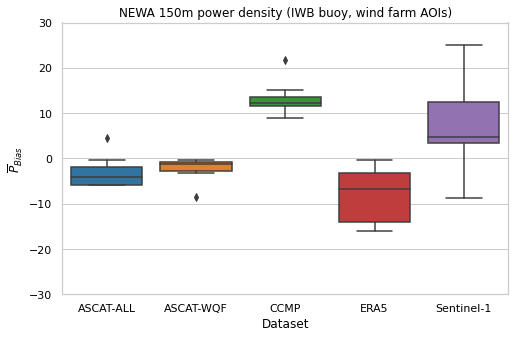

In [40]:
cubed_windspeed_estimator = CubedWindSpeedPowerDensityEstimator(air_density=newa_rhodf.RHO.mean())
weibull_power_estimator = WeibullWindSpeedPowerDensityEstimator(air_density=newa_rhodf.RHO.mean())

test_datasets = [AoiPowerDensityTestDataset(eooffshore_dataset=ascatall, 
                                            extrapolator=mean_era5_alpha_powerlaw_extrapolator, 
                                            estimator=cubed_windspeed_estimator),
                 AoiPowerDensityTestDataset(eooffshore_dataset=ascatwqf, 
                                            extrapolator=mean_era5_alpha_powerlaw_extrapolator, 
                                            estimator=weibull_power_estimator),
                 AoiPowerDensityTestDataset(eooffshore_dataset=ccmp, 
                                            extrapolator=mean_era5_alpha_powerlaw_extrapolator, 
                                            estimator=cubed_windspeed_estimator),
                 AoiPowerDensityTestDataset(eooffshore_dataset=era5, 
                                            extrapolator=era5_alpha_powerlaw_extrapolator, 
                                            estimator=cubed_windspeed_estimator),
                 AoiPowerDensityTestDataset(eooffshore_dataset=sentinel1, 
                                            extrapolator=powerlaw_extrapolator, 
                                            estimator=weibull_power_estimator)
                ]

AoiPowerDensityMetrics(reference_dataset=newa,
                       test_datasets=test_datasets,
                       comparison_height=150,
                       method='Cubed Wind Speed/Weibull');